Ce projet est réalisé par Taha HABIB et Mohamed Sadok BOUZID

# 0. Installations et bibliothèques

## Installations

In [239]:
%pip install lxml

!pip install python-dotenv
!pip install spotipy

!pip install tqdm

## Importation des bibliothèques

In [367]:
# Web scraping
import bs4
import requests
import pickle

# Utilisation du fichier .env
from dotenv import load_dotenv
import os

# Spotify api
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json # Pour lire le fichier json contenant le token

# Progress bar
from tqdm.notebook import tqdm

# Manipulation des données
import pandas as pd
import numpy as np
import ast  # Conversion de chaînes de caractères en listes

# Visualisation et analyse des données
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import gaussian_kde

# Préparation des données pour la modélisation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Modélisation
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Evaluation des modèles
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report


# I. Récupération des données

## I. 1. WebScrapping

Nous commençons par extraire les musiques et leurs artistes entre 2010 et 2023 du site 'https://www.songfacts.com/browse/years/' en bouclant sur les différentes pages 'https://www.songfacts.com/browse/years/{year}'. On les enregistre dans un dictionnaire qu'on appelle music_dict.

In [20]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}
music_dict = {}
for year in range(2010, 2024):
    url = f'https://www.songfacts.com/browse/years/{year}'
    html_response = requests.get(url, headers=headers)
    html_text = html_response.text 
    soup = bs4.BeautifulSoup(html_text,'lxml')
    page_numbers = soup.find("div", class_="pagination-result-info visible-md visible-lg visible-sm")
    #print(page_numbers.text)
    sentence = page_numbers.text.split()
    #print(sentence)
    page_number = sentence[-1]
    page_number = int(page_number)
    #print(page_number)
    for page_num in range(1, page_number):
        if page_num ==1 : 
            url = f'https://www.songfacts.com/browse/years/{year}'
        else :
            url = f'https://www.songfacts.com/browse/years/{year}/page{page_num}'
        html_response = requests.get(url, headers=headers)
        html_text = html_response.text 
        soup = bs4.BeautifulSoup(html_text,'lxml')
        music_elements = soup.select('body > div:nth-child(8) > div > div > div > ul > li')
        for music_element in music_elements: 
            music_name = music_element.text
            #print(music_name)
            element = music_name.split(' - ')
            if len(element)==2:
                #print(element)
                song, singer = element
                music_dict[song] = singer
print(music_dict)
print(len(music_dict))

FeatureNotFound: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?

Nous trouvons ainsi 22925 musiques. 

In [4]:
music_dict['3D']

'Jungkook'

En scrappant les musiques du site web, nous apercevons plutart que l'api spotify ne reconnait pas les titres/artiste dont le nom contient des apostrophes, de plus que certaines nommations sont différentes entre le site web et spotify. 

Par exemple, pour le titre '3D' de l'artiste 'JungKook', nous trouvons que Spotify l'appelle 'Jung Kook'. Donc il fallait chercher chaque titre à part pour trouver comment spotify a decidé de l'appeler. 


Nous avons commencé au début d'essayer de les corriger à la main ( comme le montre le code ci-dessous) mais vu la nature du problème, ce n'est pas automatisable. Par la suite, nous avons décider d'ignorer les ids non trouvés par l'API spotify.

In [5]:
music_dict['3D'] = 'Jung kook'
music_dict['Stuck'] = 'Thirty Seconds to Mars'
music_dict['Get Up Kid'] = 'Thirty Seconds to Mars'
music_dict['Trustfall'] = 'P!nk'
music_dict['Standing Next To You'] = 'Jung kook'
music_dict['Seven'] = 'Jung kook'
music_dict.pop("She'll Let Herself Out")
music_dict['Shell Let Herself Out'] = 'Maia Sharp'
music_dict['Beso'] = 'Rosalia, Rauw Alejandro'
music_dict['Que Onda'] = 'Calle 24, Chino Pacas, Fuerza Regida'
music_dict['Sad B!tch '] = 'Anne-Marie'
music_dict["Im Not Pretty"] = 'Megan Moroney'
music_dict.pop("Can't Break Up Now") 
music_dict['Cant Break Up Now'] = 'Old Dominion, Megan Moroney'
music_dict.pop("Can't Tame Her")
music_dict['Cant Tame Her'] = 'Zara Larsson'
music_dict.pop('Can\'t Outrun The Truth')
music_dict['Cant Outrun The Truth'] ='Pete Townshend'
music_dict.pop('All My Sh-t Is In My Car')
music_dict['All My Shit Is In My Car'] = 'JP Saxe'
music_dict['Vultures'] = '¥$, Kanye West, Ty Dolla $ign, Bump J, Lil Durk'
music_dict.pop("Don't Forget Me")
music_dict['Dont Forget Me'] ='Dermot Kennedy'
music_dict.pop("Don't Say Love")
music_dict["Dont Say Love"] = 'Leigh-Anne'
music_dict.pop("Haven't You Ever Been In Love Before?")
music_dict["Havent You Ever Been In Love Before?"] = 'Lewis Capaldi'
music_dict.pop("Hum's Liquor")
music_dict.pop("Can't Play Myself (A Tribute To Amy)")
music_dict['Cant Play Myself (A Tribute To Amy)'] = 'Skepta'

music_dict.pop("I'll Be Holding On")
music_dict['Ill Be Holding On']='Morgan James'
music_dict.pop("I'm Not Here To Make Friends")
music_dict['Im Not Here To Make Friends']='Sam Smith'
music_dict.pop("I'm Not Pretty")
music_dict["Im Not Pretty"]='Megan Moroney'
music_dict.pop("J'adore")
music_dict['Jadore']='Strandz'
music_dict["Money On The Dash"]='Whethan,elley, Duhé'
music_dict.pop("Sad Bitch")
music_dict['Sad B!tch']='Anne-Marie'
music_dict.pop("DIwhy")
music_dict.pop("Money On The Dash")


'Whethan,elley,\xa0Duhé'

Afin de ne pas lancer à chaque fois le code de scrapping, nous décidons d'enregistrer le dictionnaire music_dict sous forme de '.pkl'.

In [7]:
#with open('music_dict.pkl', 'wb') as file:
    #pickle.dump(music_dict, file)

Ainsi à chaque utilisation du code, nous ne lançons que la cellule ci-dessous

In [241]:
with open('music_dict.pkl', 'rb') as file:
        music_dict = pickle.load(file)
print(music_dict)
print(len(music_dict))

{'(Ha Ha) Slow Down': 'Fat Joe', "(I Can't Make It) Another Day": 'Michael Jackson', '(I Like) The Way You Love Me': 'Michael Jackson', "(It's Not War) Just the End of Love": 'Manic Street Preachers', '...And the World Laughs With You': 'Flying Lotus', '1+1': 'Beyoncé', '1,000 Faces': 'Randy Montana', '10 Seconds': 'Jazmine Sullivan', '100 Years From Now': 'Karen Elson', '1000 Years': 'The Coral', '187': "Lil' Boosie", '1979': 'Good Charlotte', '1983': 'Neon Trees', '2 Fat Ladies': 'Paul Weller', '2 Sides of Me': 'Hinder', '2012': 'The Word Alive', "2012 (It Ain't the End)": 'Jay Sean', '21@12': 'Hot Hot Heat', '25 to Life': 'Eminem', '30 Thousand 100 Million': 'Soulja Boy', '4 June 1989': 'Mary Chapin Carpenter', '4th of July (Fireworks)': 'Kelis', '6 Foot 7 Foot': 'Lil Wayne', '7 Day Binge': '7dayBinge', "7&3 is the Striker's Name": 'Paul Weller', '7x70': 'Chris August', '81': 'Joanna Newsom', '@!#?@! (swear words)': 'Motion City Soundtrack', 'A Billion Balconies Facing the Sun': 'Ma

## I. 2. Utilisation de l'API Spotify

Nous utilisons l'API Spotify et plus spécialement la Web API. Pour cela nous avons dû créer une application sur le site Spotify for Developers, pour ainsi avoir un `Client ID` et un `Client secret` propre à notre application, qui nous permettront de nous authentifier et d'accéder aux données de Spotify. 

Nous les stockons dans un fichier .env dont nous faisons l'appel grâce à la fonction suivante.


En pratique, nous avons stocké plusieurs identifiants, nous verrons pourquoi par la suite.
Nous créons ainsi une fonction `load_credentials(num)` qui prend en argument un numéro. Cette fonction utilise ce numéro pour récupérer les identifiants correspondants 'Client ID' et 'Client Secret' depuis notre fichier `.env`. Ces identifiants sont ensuite retournés par la fonction, nous permettant d'utiliser différents jeux d'identifiants en fonction du numéro que nous passons à la fonction.

In [242]:
def load_credentials(num):
    load_dotenv()

    client_secret = os.getenv(f"CLIENT_SECRET{num}")
    client_id = os.getenv(f"CLIENT_ID{num}")

    return client_secret, client_id

In [243]:
client_secret, client_id = load_credentials(1)
print(client_secret)
print(client_id)

18e61a3505fc4055a01c5098b7bd6663
cdfb4eebae314c088bcdcaf2795655fa


En utilisant le dictionnaire `music_dict`, nous recherchons chaque musique sur l'API Spotify en utilisant son nom et celui de l'artiste correspondant. Nous stockons ensuite l'ID de la musique, son nom, le nom de l'artiste, la popularité et l'année de sortie dans des listes séparées.

Pour cela, nous avons besoin d'un deuxième type d'authentification afin que l'API spotify ne se bloque pas.

In [244]:
def get_access_token(client_id: str, client_secret: str, grant_type: str = 'client_credentials'):
    url = 'https://accounts.spotify.com/api/token?grant_type={}&client_id={}&client_secret={}'.format(grant_type, client_id, client_secret)
    response = requests.post(url, headers={'Content-Type':'application/x-www-form-urlencoded'})
    access_token = 'Bearer ' + json.loads(response.text)['access_token']

    return access_token

Nous récupérons ainsi le token d'accés et nous le stockons dans `acces_token`

In [245]:
# Récupération du token
grant_type = 'client_credentials'
client_id = os.getenv('CLIENT_ID1')
client_secret = os.getenv('CLIENT_SECRET1')

access_token = get_access_token(client_id, client_secret, grant_type)

La fonction suivante est une fonction générique pour effectuer des appels d'API en fournissant uniquement l'URL cible et un jeton d'accès 

In [246]:
def get_data(url: str, access_token: str, verbose: bool = False):
    response = requests.get(url, headers={'Authorization': access_token})
    result = json.loads(response.text)

    if verbose:
        print('Response body:\n', result)

    return result

Nous définissons ainsi la fonction qu'on va utiliser pour récupérer l'id, la popularité et l'année de sortie de chaque music de notre dictionnaire.

In [247]:
def get_tracks(music_dict: dict, access_token: str):
    tracks_df = pd.DataFrame()

    for track_name, artist_name in tqdm(music_dict.items()):
        url = f'https://api.spotify.com/v1/search?q=track:{track_name}%20artist:{artist_name}&type=track&limit=1'
        search_item = get_data(url, access_token)

        if 'tracks' in search_item and search_item['tracks']['items']:
            track_id = search_item['tracks']['items'][0]['id']
            popularity = search_item['tracks']['items'][0]['popularity']
            release_date = search_item['tracks']['items'][0]['album']['release_date']
            release_year = release_date.split('-')[0]  # Extract the year from the release date

            tracks_df = tracks_df.append({
                'track_id': track_id,
                'track_name': track_name,
                'artist_name': artist_name,
                'popularity': popularity,
                'release_year': release_year,
            }, ignore_index=True)

    return tracks_df

In [ ]:
tracks_df = get_tracks(music_dict, access_token)
#Afficher le dataset
tracks_df

  0%|          | 0/22923 [00:00<?, ?it/s]

100%|██████████| 22923/22923 [56:38<00:00,  6.74it/s]  


track_id                           track_name  \
0      2GSvDs1qdhcPpfawycouWy                    (Ha Ha) Slow Down   
1      5OgTq4ExF13EdcLD6PSYuN        (I Can't Make It) Another Day   
2      3VDJf1JQWl9m3H1JgdhUNj         (I Like) The Way You Love Me   
3      5STqmIsYNIaupSUZrcDgaZ     ...And the World Laughs With You   
4      02M6vucOvmRfMxTXDUwRXu                                  1+1   
...                       ...                                  ...   
21025  6GrLwf1LdBCmkBOsmOcbPp  Cant Play Myself (A Tribute To Amy)   
21026  1u0dFbfSzHikHWe6olHYkn                    Ill Be Holding On   
21027  3i0FkJYlU4MFfYkjFHXXAM          Im Not Here To Make Friends   
21028  1ZiBudnpvQfopaxd8bbDLD                               Jadore   
21029  4nfyxpiejEPrUHLnejED7i                            Sad B!tch   

           artist_name  popularity release_year  
0              Fat Joe        32.0         2010  
1      Michael Jackson        36.0         2010  
2      Michael Jackson        44.0         2010  
3         Flying Lotus        35.0         2010  
4              Beyoncé        68.0         2014  
...                ...         ...          ...  
21025           Skepta        67.0         2023  
21026     Morgan James         8.0         2023  
21027        Sam Smith        71.0         2023  
21028          Strandz        61.0         2023  
21029       Anne-Marie        52.0         2023  

[21030 rows x 5 columns]

Le dataset contient ainsi 5 colonnes : `Track Name`, `Artist Name`, `Track ID` et `Release Year` et `Popularity`. On le stocke aussi pour ne pas relancer l'étape d'extraction à chaque fois.

In [ ]:
#tracks_df.to_csv('tracks.csv', index=False)

In [279]:
tracks_df = pd.read_csv('tracks.csv')

Nous retrouvons ainsi 21030 musiques sur 22923 musiques au départ, cela est dû à ce qu'on a expliqué plus haut, que certaines musiques ne sont pas retrouvables par Spotify lors de la recherche.

Maintenant, il ne nous manque que les features audio. Pour les extraire, nous allons utiliser les IDs que nous venons de récupérer et nous rappelons l'API mais cette fois nous changeons la méthode d'authentification. 

Afin d'extraire les caractéristiques audio des différentes musiques, il nous faut les IDs des différentes musiques. C'est pour cela, nous récupérons les IDs des musiques de la base de données que nous venons d'obtenir et nous les stockons dans la liste `tracks_ids`

In [281]:
tracks_ids = tracks_df['track_id'].tolist()

Dans ce bloc de code, nous initialisons l'authentification avec l'API Spotify. Nous créons un objet `spotifyObject` qui sera utilisé pour interagir avec l'API. Ce type d'authentification nous sera utile pour extraire les features audio des musiques.

In [273]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
spotifyObject = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

Dans le code qui suit, nous récupérons les caractéristiques audio de chaque musique à partir de son ID Spotify. Comme la méthode `audio_features` de l'API Spotify a une limite de 100 ID par requête, nous divisons notre liste d'ID de musiques en sous-listes de 100 ID ou moins. Ensuite, nous bouclons sur ces sous-listes pour récupérer les caractéristiques audio de toutes les musiques. Les caractéristiques récupérées sont ensuite ajoutées à la liste `features_list`.

In [ ]:
n = len(tracks_ids)
num_iter = n//100

track_id_part = [tracks_ids[i*100: (i+1)*100] for i in range(num_iter)]
track_id_part.append(tracks_ids[num_iter*100:])

features_list = []
for tr in tqdm(track_id_part):
    features = spotifyObject.audio_features(tr)
    features_list.extend(features)

100%|██████████| 211/211 [00:26<00:00,  8.05it/s]


Nous stockons le jeu de données des caractéristiques `features_df` pour éviter de recommencer depuis le début en cas d'erreur ultérieure.


In [ ]:
#features_df.to_csv('features_df.csv', index=False)

In [282]:
features_df = pd.read_csv('features_df.csv')

In [283]:
print(len(features_df))

21030


In [25]:
features_df.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.307   0.879    9    -5.557     1       0.5280      0.123000   
1         0.682   0.837    2    -4.654     1       0.1160      0.033900   
2         0.626   0.662    0    -4.272     1       0.0282      0.307000   
3         0.538   0.886    5    -5.310     1       0.0309      0.000078   
4         0.637   0.717    8    -7.635     0       0.1430      0.185000   

   instrumentalness  liveness  valence    tempo            type  \
0          0.000000    0.0621    0.407  190.393  audio_features   
1          0.000007    0.0471    0.886   90.019  audio_features   
2          0.000016    0.2410    0.511   94.993  audio_features   
3          0.025400    0.2100    0.565  138.993  audio_features   
4          0.497000    0.1410    0.541   80.926  audio_features   

                       id                                   uri  \
0  2GSvDs1qdhcPpfawycouWy  spotify:track:2GSvDs1qdhcPpfawycouWy   
1  5OgTq4ExF13EdcLD6PSYuN  spotify:track:5OgTq4ExF13EdcLD6PSYuN   
2  3VDJf1JQWl9m3H1JgdhUNj  spotify:track:3VDJf1JQWl9m3H1JgdhUNj   
3  6s57NVutjlmejmjTJr3Sj0  spotify:track:6s57NVutjlmejmjTJr3Sj0   
4  5STqmIsYNIaupSUZrcDgaZ  spotify:track:5STqmIsYNIaupSUZrcDgaZ   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2GSvDs1qdhcP...   
1  https://api.spotify.com/v1/tracks/5OgTq4ExF13E...   
2  https://api.spotify.com/v1/tracks/3VDJf1JQWl9m...   
3  https://api.spotify.com/v1/tracks/6s57NVutjlme...   
4  https://api.spotify.com/v1/tracks/5STqmIsYNIau...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/2GSv...       205000   
1  https://api.spotify.com/v1/audio-analysis/5OgT...       234413   
2  https://api.spotify.com/v1/audio-analysis/3VDJ...       273800   
3  https://api.spotify.com/v1/audio-analysis/6s57...       208053   
4  https://api.spotify.com/v1/audio-analysis/5STq...       175040   

   time_signature  
0               4  
1               4  
2               4  
3               4  
4               4

On fusionne maintenant les 2 dataset `features_df` et `tracks_df`

In [284]:
# Fusionner les deux DataFrames sur la colonne 'Track ID'
merged_df = pd.merge(tracks_df, features_df, how='left', left_on='track_id', right_on='id')

# Supprimer les lignes où une caractéristique est None
merged_df = merged_df.dropna(subset=features_df.columns[features_df.isna().any()].tolist())

In [277]:
merged_df.head()

track_id                        track_name      artist_name  \
0  2GSvDs1qdhcPpfawycouWy                 (Ha Ha) Slow Down          Fat Joe   
1  5OgTq4ExF13EdcLD6PSYuN     (I Can't Make It) Another Day  Michael Jackson   
2  3VDJf1JQWl9m3H1JgdhUNj      (I Like) The Way You Love Me  Michael Jackson   
3  5STqmIsYNIaupSUZrcDgaZ  ...And the World Laughs With You     Flying Lotus   
4  02M6vucOvmRfMxTXDUwRXu                               1+1          Beyoncé   

   popularity  release_year  danceability  energy  key  loudness  mode  ...  \
0        32.0          2010         0.307   0.879    9    -5.557     1  ...   
1        36.0          2010         0.682   0.837    2    -4.654     1  ...   
2        44.0          2010         0.626   0.662    0    -4.272     1  ...   
3        35.0          2010         0.637   0.717    8    -7.635     0  ...   
4        68.0          2014         0.747   0.705    9    -5.137     0  ...   

   liveness  valence    tempo            type                      id  \
0    0.0621    0.407  190.393  audio_features  2GSvDs1qdhcPpfawycouWy   
1    0.0471    0.886   90.019  audio_features  5OgTq4ExF13EdcLD6PSYuN   
2    0.2410    0.511   94.993  audio_features  3VDJf1JQWl9m3H1JgdhUNj   
3    0.1410    0.541   80.926  audio_features  5STqmIsYNIaupSUZrcDgaZ   
4    0.1260    0.560  136.024  audio_features  02M6vucOvmRfMxTXDUwRXu   

                                    uri  \
0  spotify:track:2GSvDs1qdhcPpfawycouWy   
1  spotify:track:5OgTq4ExF13EdcLD6PSYuN   
2  spotify:track:3VDJf1JQWl9m3H1JgdhUNj   
3  spotify:track:5STqmIsYNIaupSUZrcDgaZ   
4  spotify:track:02M6vucOvmRfMxTXDUwRXu   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2GSvDs1qdhcP...   
1  https://api.spotify.com/v1/tracks/5OgTq4ExF13E...   
2  https://api.spotify.com/v1/tracks/3VDJf1JQWl9m...   
3  https://api.spotify.com/v1/tracks/5STqmIsYNIau...   
4  https://api.spotify.com/v1/tracks/02M6vucOvmRf...   

                                        analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/2GSv...      205000   
1  https://api.spotify.com/v1/audio-analysis/5OgT...      234413   
2  https://api.spotify.com/v1/audio-analysis/3VDJ...      273800   
3  https://api.spotify.com/v1/audio-analysis/5STq...      175040   
4  https://api.spotify.com/v1/audio-analysis/02M6...      213507   

  time_signature  
0              4  
1              4  
2              4  
3              4  
4              4  

[5 rows x 23 columns]

In [285]:
merged_df

track_id                        track_name  \
0      2GSvDs1qdhcPpfawycouWy                 (Ha Ha) Slow Down   
1      5OgTq4ExF13EdcLD6PSYuN     (I Can't Make It) Another Day   
2      3VDJf1JQWl9m3H1JgdhUNj      (I Like) The Way You Love Me   
3      5STqmIsYNIaupSUZrcDgaZ  ...And the World Laughs With You   
4      02M6vucOvmRfMxTXDUwRXu                               1+1   
...                       ...                               ...   
21337  1u0dFbfSzHikHWe6olHYkn                 Ill Be Holding On   
21338  3i0FkJYlU4MFfYkjFHXXAM       Im Not Here To Make Friends   
21339  1ZiBudnpvQfopaxd8bbDLD                            Jadore   
21340  4nfyxpiejEPrUHLnejED7i                         Sad B!tch   
21341  4nfyxpiejEPrUHLnejED7i                         Sad B!tch   

           artist_name  popularity  release_year  danceability  energy  key  \
0              Fat Joe        32.0          2010         0.307   0.879    9   
1      Michael Jackson        36.0          2010         0.682   0.837    2   
2      Michael Jackson        44.0          2010         0.626   0.662    0   
3         Flying Lotus        35.0          2010         0.637   0.717    8   
4              Beyoncé        68.0          2014         0.747   0.705    9   
...                ...         ...           ...           ...     ...  ...   
21337     Morgan James         8.0          2023         0.425   0.469    5   
21338        Sam Smith        71.0          2023         0.698   0.895    0   
21339          Strandz        61.0          2023         0.597   0.470    6   
21340       Anne-Marie        52.0          2023         0.544   0.692    0   
21341       Anne-Marie        52.0          2023         0.544   0.692    0   

       loudness  mode  ...  liveness  valence    tempo            type  \
0        -5.557     1  ...    0.0621    0.407  190.393  audio_features   
1        -4.654     1  ...    0.0471    0.886   90.019  audio_features   
2        -4.272     1  ...    0.2410    0.511   94.993  audio_features   
3        -7.635     0  ...    0.1410    0.541   80.926  audio_features   
4        -5.137     0  ...    0.1260    0.560  136.024  audio_features   
...         ...   ...  ...       ...      ...      ...             ...   
21337    -9.290     0  ...    0.1890    0.495  132.264  audio_features   
21338    -4.439     1  ...    0.4090    0.838  114.914  audio_features   
21339    -8.609     0  ...    0.0964    0.728  120.493  audio_features   
21340    -3.207     0  ...    0.1310    0.618  193.954  audio_features   
21341    -3.207     0  ...    0.1310    0.618  193.954  audio_features   

                           id                                   uri  \
0      2GSvDs1qdhcPpfawycouWy  spotify:track:2GSvDs1qdhcPpfawycouWy   
1      5OgTq4ExF13EdcLD6PSYuN  spotify:track:5OgTq4ExF13EdcLD6PSYuN   
2      3VDJf1JQWl9m3H1JgdhUNj  spotify:track:3VDJf1JQWl9m3H1JgdhUNj   
3      5STqmIsYNIaupSUZrcDgaZ  spotify:track:5STqmIsYNIaupSUZrcDgaZ   
4      02M6vucOvmRfMxTXDUwRXu  spotify:track:02M6vucOvmRfMxTXDUwRXu   
...                       ...                                   ...   
21337  1u0dFbfSzHikHWe6olHYkn  spotify:track:1u0dFbfSzHikHWe6olHYkn   
21338  3i0FkJYlU4MFfYkjFHXXAM  spotify:track:3i0FkJYlU4MFfYkjFHXXAM   
21339  1ZiBudnpvQfopaxd8bbDLD  spotify:track:1ZiBudnpvQfopaxd8bbDLD   
21340  4nfyxpiejEPrUHLnejED7i  spotify:track:4nfyxpiejEPrUHLnejED7i   
21341  4nfyxpiejEPrUHLnejED7i  spotify:track:4nfyxpiejEPrUHLnejED7i   

                                              track_href  \
0      https://api.spotify.com/v1/tracks/2GSvDs1qdhcP...   
1      https://api.spotify.com/v1/tracks/5OgTq4ExF13E...   
2      https://api.spotify.com/v1/tracks/3VDJf1JQWl9m...   
3      https://api.spotify.com/v1/tracks/5STqmIsYNIau...   
4      https://api.spotify.com/v1/tracks/02M6vucOvmRf...   
...                                                  ...   
21337  https://api.spotify.com/v1/tracks/1u0dFbfSzHik...   
21338  https://api.spotify.com/v1/tracks/3i0F

Nous remarquons que nous trouvons des doublons, on s'en occupera dans la partie Data Cleaning

In [286]:
merged_df = merged_df.rename(columns={
    'track_id': 'Track ID',
    'track_name': 'Track Name',
    'artist_name': 'Artist Name',
    'popularity': 'Popularity',
    'release_year': 'Release Year',
})

Nous stockons cette base de données aussi 

In [288]:
#merged_df.to_csv('final_dataset.csv', index=False)

In [234]:
final_dataset = pd.read_csv('final_dataset.csv')

In [235]:
print(final_dataset.dtypes)

Track ID             object
Track Name           object
Artist Name          object
Popularity          float64
Release Year          int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
dtype: object


Regardons de plus près les types de chaque colonnes

In [236]:
def print_type_counts(df):
    type_counts_per_column = {}
    dominant_types_per_column = {}

    for column in df.columns:
        type_counts = df[column].apply(type).value_counts()
        type_counts_per_column[column] = type_counts
        dominant_types_per_column[column] = type_counts.index[0]

    for column, counts in type_counts_per_column.items():
        print(f"Column: {column}")
        print(counts)
        print("------------------")
    
    return dominant_types_per_column

In [237]:
dominant_types = print_type_counts(final_dataset)

Column: Track ID
<class 'str'>    21342
Name: Track ID, dtype: int64
------------------
Column: Track Name
<class 'str'>    21342
Name: Track Name, dtype: int64
------------------
Column: Artist Name
<class 'str'>    21342
Name: Artist Name, dtype: int64
------------------
Column: Popularity
<class 'float'>    21342
Name: Popularity, dtype: int64
------------------
Column: Release Year
<class 'int'>    21342
Name: Release Year, dtype: int64
------------------
Column: danceability
<class 'float'>    21342
Name: danceability, dtype: int64
------------------
Column: energy
<class 'float'>    21342
Name: energy, dtype: int64
------------------
Column: key
<class 'int'>    21342
Name: key, dtype: int64
------------------
Column: loudness
<class 'float'>    21342
Name: loudness, dtype: int64
------------------
Column: mode
<class 'int'>    21342
Name: mode, dtype: int64
------------------
Column: speechiness
<class 'float'>    21342
Name: speechiness, dtype: int64
------------------
Column: 

Nous remarquons que les types par colonne sont homogènes.

Lors de l'extraction des popularités avec l'API spotify, nous avons rencontré quelques difficultés. En effet, hormis le nombre limité de requêtes que nous offre l'API spotify par ID Client et Client Secret, le token utilisé pour chaque client n'est pas reintialisé après chaque appel. Ce qui fait que nous avons dû supprimer à le fichier .cache après chaque appel. 
De là l'automatisation du code en utilisant une boucle ne marche pas.

Finalement, nous avons trouvé une solution pour résoudre ce problème. Nous avons trouvé une nouvelle manière d'authentification qui nous permet de faire autant de requête qu'on veut en stockant le tocken et en le précisant à chaque appel de l'API à la place de le laisser se générer tout seul.

# II. Prise en main de la base de données

## II. 1. Data cleaning

In [289]:
dataframe = pd.read_csv('final_dataset.csv')

In [290]:
dataframe.columns

Index(['Track ID', 'Track Name', 'Artist Name', 'Popularity', 'Release Year',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [291]:
dataframe.head()

Track ID                        Track Name      Artist Name  \
0  2GSvDs1qdhcPpfawycouWy                 (Ha Ha) Slow Down          Fat Joe   
1  5OgTq4ExF13EdcLD6PSYuN     (I Can't Make It) Another Day  Michael Jackson   
2  3VDJf1JQWl9m3H1JgdhUNj      (I Like) The Way You Love Me  Michael Jackson   
3  5STqmIsYNIaupSUZrcDgaZ  ...And the World Laughs With You     Flying Lotus   
4  02M6vucOvmRfMxTXDUwRXu                               1+1          Beyoncé   

   Popularity  Release Year  danceability  energy  key  loudness  mode  ...  \
0        32.0          2010         0.307   0.879    9    -5.557     1  ...   
1        36.0          2010         0.682   0.837    2    -4.654     1  ...   
2        44.0          2010         0.626   0.662    0    -4.272     1  ...   
3        35.0          2010         0.637   0.717    8    -7.635     0  ...   
4        68.0          2014         0.747   0.705    9    -5.137     0  ...   

   liveness  valence    tempo            type                      id  \
0    0.0621    0.407  190.393  audio_features  2GSvDs1qdhcPpfawycouWy   
1    0.0471    0.886   90.019  audio_features  5OgTq4ExF13EdcLD6PSYuN   
2    0.2410    0.511   94.993  audio_features  3VDJf1JQWl9m3H1JgdhUNj   
3    0.1410    0.541   80.926  audio_features  5STqmIsYNIaupSUZrcDgaZ   
4    0.1260    0.560  136.024  audio_features  02M6vucOvmRfMxTXDUwRXu   

                                    uri  \
0  spotify:track:2GSvDs1qdhcPpfawycouWy   
1  spotify:track:5OgTq4ExF13EdcLD6PSYuN   
2  spotify:track:3VDJf1JQWl9m3H1JgdhUNj   
3  spotify:track:5STqmIsYNIaupSUZrcDgaZ   
4  spotify:track:02M6vucOvmRfMxTXDUwRXu   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2GSvDs1qdhcP...   
1  https://api.spotify.com/v1/tracks/5OgTq4ExF13E...   
2  https://api.spotify.com/v1/tracks/3VDJf1JQWl9m...   
3  https://api.spotify.com/v1/tracks/5STqmIsYNIau...   
4  https://api.spotify.com/v1/tracks/02M6vucOvmRf...   

                                        analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/2GSv...      205000   
1  https://api.spotify.com/v1/audio-analysis/5OgT...      234413   
2  https://api.spotify.com/v1/audio-analysis/3VDJ...      273800   
3  https://api.spotify.com/v1/audio-analysis/5STq...      175040   
4  https://api.spotify.com/v1/audio-analysis/02M6...      213507   

  time_signature  
0              4  
1              4  
2              4  
3              4  
4              4  

[5 rows x 23 columns]

On commence par éliminer les colonnes non nécessaires

In [292]:
dataframe = dataframe.drop(columns=['type','id','uri','track_href','analysis_url', 'Track ID', 'time_signature'])
dataframe.columns

Index(['Track Name', 'Artist Name', 'Popularity', 'Release Year',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [293]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21342 entries, 0 to 21341
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track Name        21342 non-null  object 
 1   Artist Name       21342 non-null  object 
 2   Popularity        21342 non-null  float64
 3   Release Year      21342 non-null  int64  
 4   danceability      21342 non-null  float64
 5   energy            21342 non-null  float64
 6   key               21342 non-null  int64  
 7   loudness          21342 non-null  float64
 8   mode              21342 non-null  int64  
 9   speechiness       21342 non-null  float64
 10  acousticness      21342 non-null  float64
 11  instrumentalness  21342 non-null  float64
 12  liveness          21342 non-null  float64
 13  valence           21342 non-null  float64
 14  tempo             21342 non-null  float64
 15  duration_ms       21342 non-null  int64  
dtypes: float64(10), int64(4), object(2)
memo

On compte le nombre de valeurs manquantes pour chaque variable dans notre base de données

In [294]:
dataframe.isna().sum()

Track Name          0
Artist Name         0
Popularity          0
Release Year        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64

 On remarque qu'il n'existe pas de valeurs nuls

Nous utilisons la méthode `duplicated()` pour repérer les lignes en double.
Cela nous donne un aperçu du nombre des doublons présents dans les données:

In [295]:
doublons = dataframe.duplicated()

print(f"Nombre de lignes en double = {doublons.sum()}")

Nombre de lignes en double = 312


En utilisant la fonction drop_duplicates(), nous éliminons les lignes en double du DataFrame.
 Cela permet d'assurer que chaque ligne représente une observation unique

In [296]:
# Drop les doublons
dataframe = dataframe.drop_duplicates()

print(f"Nombre de lignes restantes = {dataframe.shape[0]}")

Nombre de lignes restantes = 21030


Nous remarquons que la durée est de l'ordre de 10^5. Afin de mieux manipuler les données, nous convertissons les durées en minutes:

In [297]:
dataframe['duration_ms'] = dataframe['duration_ms'] / 60000

dataframe.rename(columns={'duration_ms': 'duration_min'}, inplace=True)

On enregistre la base de données avant pré-traitement pour toute utilisations ultérieures

In [298]:
#dataframe.to_csv('dataframe.csv', index=False)

In [299]:
dataframe = pd.read_csv('dataframe.csv')

## II. 2. Analyse exploratoire des données

In [300]:
display(dataframe.describe())

Popularity  Release Year  danceability        energy           key  \
count  21030.000000  21030.000000  21030.000000  21030.000000  21030.000000   
mean      39.000476   2015.589444      0.559479      0.676383      5.178982   
std       20.809666      4.366465      0.152536      0.213695      3.604623   
min        0.000000   1926.000000      0.000000      0.000242      0.000000   
25%       23.000000   2013.000000      0.461000      0.538000      2.000000   
50%       38.000000   2015.000000      0.561000      0.713000      5.000000   
75%       55.000000   2019.000000      0.664000      0.849000      8.000000   
max       96.000000   2023.000000      0.977000      0.999000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  21030.000000  21030.000000  21030.000000  21030.000000   
mean      -6.658661      0.679078      0.082207      0.214706   
std        3.067127      0.466842      0.090314      0.275357   
min      -46.511000      0.000000      0.000000      0.000001   
25%       -7.927750      0.000000      0.034000      0.009270   
50%       -6.002500      1.000000      0.046200      0.077200   
75%       -4.631000      1.000000      0.083800      0.337000   
max        1.348000      1.000000      0.945000      0.996000   

       instrumentalness      liveness       valence         tempo  \
count      21030.000000  21030.000000  21030.000000  21030.000000   
mean           0.050141      0.187863      0.451036    123.381538   
std            0.164016      0.144102      0.224810     29.497189   
min            0.000000      0.016500      0.000000      0.000000   
25%            0.000000      0.098500      0.274000    100.002000   
50%            0.000013      0.127000      0.433000    122.054500   
75%            0.002107      0.242000      0.618000    142.762500   
max            0.995000      0.996000      0.983000    220.217000   

       duration_min  
count  21030.000000  
mean       3.861704  
std        1.149898  
min        0.173117  
25%        3.248217  
50%        3.687350  
75%        4.247783  
max       42.181117

### II. 2.1 Variables catégorielles VS varibales continues

D'après la documentation de l'API spotify, on a des variables de types catégorielles et d'autres continues. Ainsi, afin de mieux décrire chaque variable nous séparons ces deux types de variables.

In [301]:
unique_key = dataframe['key'].unique()
unique_mode = dataframe['mode'].unique()

print("Unique values for 'key':", unique_key)
print("Unique values for 'mode':", unique_mode)

Unique values for 'key': [ 9  2  0  8 10  6 11  5  4  1  7  3]
Unique values for 'mode': [1 0]


Nous remarquons bien que les 2 variables Mode et Key prennent des valeurs entières bien précises.

In [302]:
categorical_var = ['Release Year', 'Track Name', 'Artist Name', 'key', 'mode']
continuous_var = dataframe.drop(columns=categorical_var).columns.to_list()
print(continuous_var)

['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_min']


#### II. 2.1.1. Visualisation des variables continues:

Nous avons utilisé les histogrammes pour analyser des données continues:

                                 Numeric Features Distribution                                  


c:\Users\tahah\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\tahah\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\tahah\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

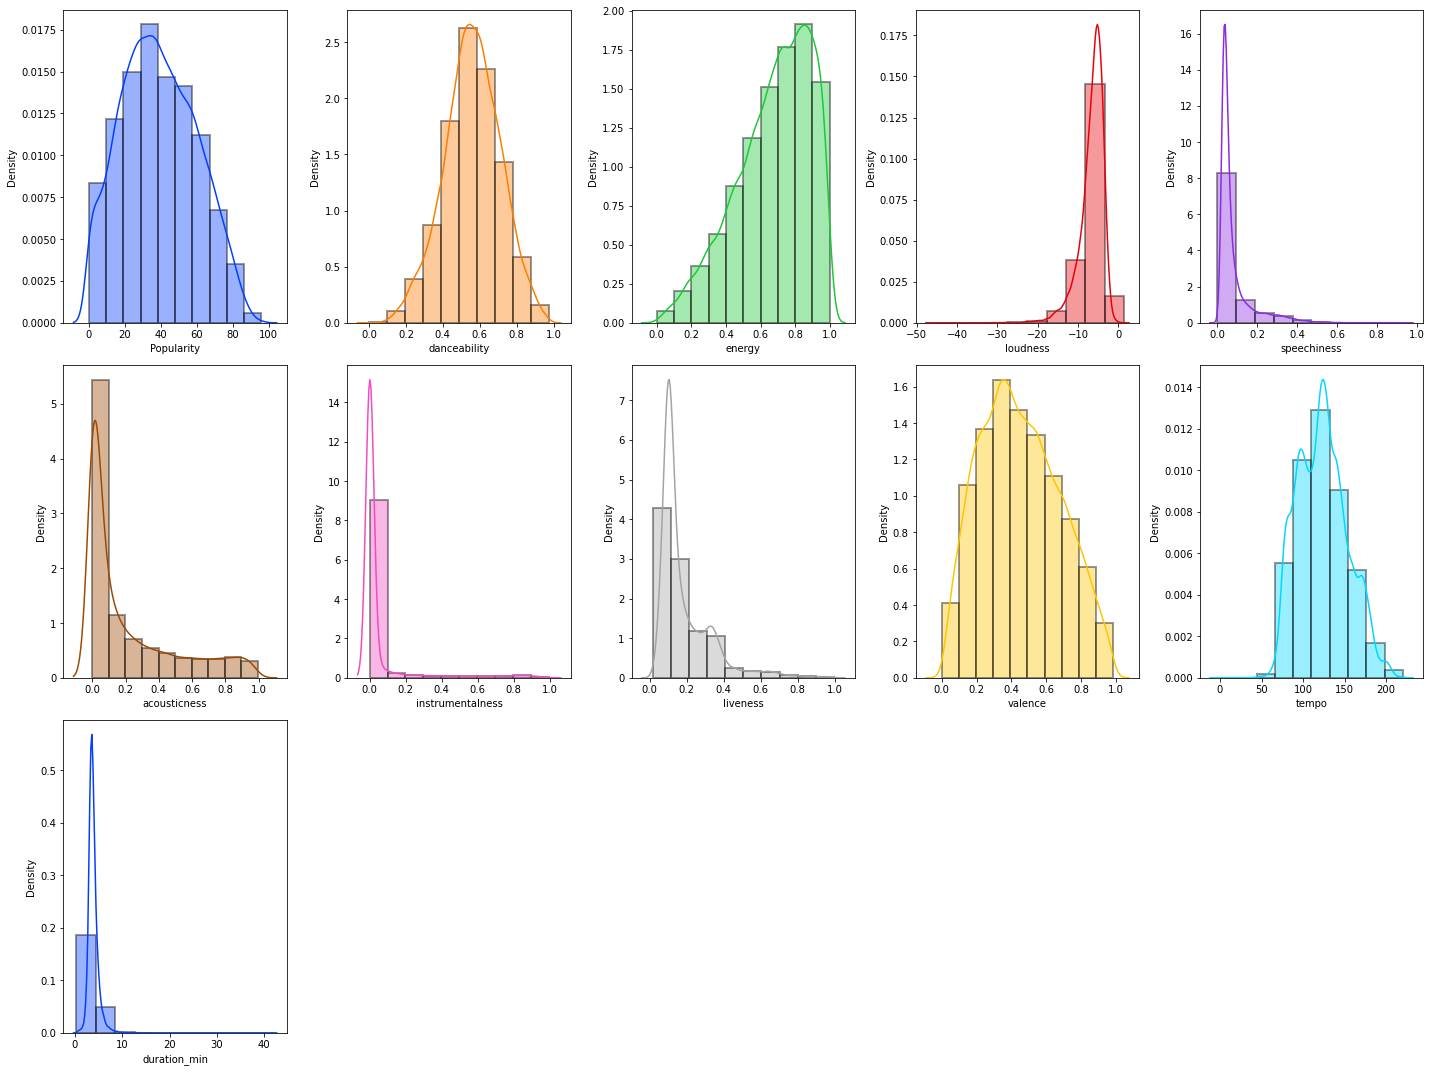

In [303]:
# Utiliser la palette de couleurs seaborn pour une meilleure différenciation
clr = sns.color_palette('bright', len(continuous_var))

# Visualisation des caractéristiques numériques avec des histogrammes
print('\033[1mNumeric Features Distribution'.center(100))

n = 5

# Augmenter la taille de la figure pour une meilleure visibilité
plt.figure(figsize=[20, 5 * math.ceil(len(continuous_var) / n)])
for i in range(len(continuous_var)):
    # Créer un sous-plot pour chaque caractéristique numérique
    plt.subplot(math.ceil(len(continuous_var) / n), n, i + 1)
    # Dessiner un histogramme pour la caractéristique numérique actuelle
    sns.distplot(dataframe[continuous_var[i]], hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=clr[i])
plt.tight_layout()
plt.show()

On remarque que les variables: tempo,valence,popularity ont des distributions symétriques, tandis que le reste des variables continues ont des distributions asymétriques:  
-   Asymétrique à droite (loudness,energy)  
-   Asymétrique à gauche (liveness,instrumentalness,duration_min,acousticness)

Regardons de plus prés la distribution de la variable `Popularity` 

Moyenne de la Popularité : 39.00
Écart type de la Popularité : 20.81


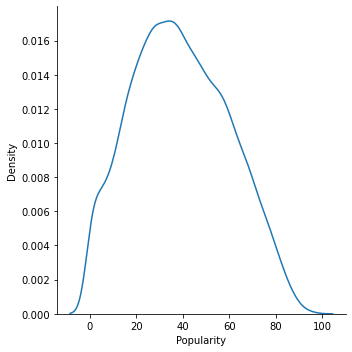

In [304]:
# Générer un graphique KDE
sns.displot(dataframe['Popularity'], kind='kde')

# Extraire les valeurs numériques associées au graphique
kde = gaussian_kde(dataframe['Popularity'])
x_values = np.linspace(min(dataframe['Popularity']), max(dataframe['Popularity']), 1000)
y_values = kde(x_values)

# Calculer la moyenne et l'écart type
moyenne = np.mean(dataframe['Popularity'])
ecart_type = np.std(dataframe['Popularity'])

# Afficher les statistiques numériques
print(f"Moyenne de la Popularité : {moyenne:.2f}")
print(f"Écart type de la Popularité : {ecart_type:.2f}")



Nous remarquon qu'elle a une moyenne de 39, et un écart type de 20 ce qui reflète une variabilité considérable autour de cette moyenne. Nous remarquons aussi un manque de musiques avec des popularités elevées et des popularités proches de 0.

#### II. 2.1.2. Variables categorielles:

Les variables 'key' et 'mode', présentent un caractère distinct dans leur distribution, car elles ne sont pas continues, mais plutôt discrètes. Afin d'avoir une visualisation plus claire, nous proposons de visualiser la fréquence des valeurs prises par chaque variable catégorielle.

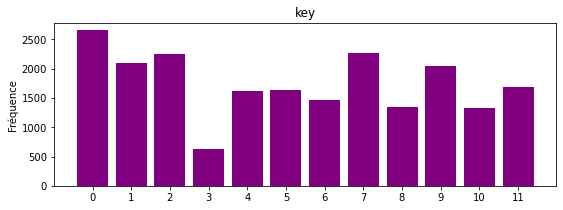

key:
0     2653
7     2272
2     2252
1     2097
9     2048
11    1692
5     1629
4     1617
6     1458
8     1353
10    1329
3      630
Name: key, dtype: int64


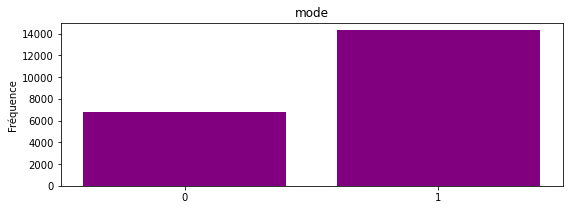

mode:
1    14281
0     6749
Name: mode, dtype: int64


In [305]:
category = ['key', 'mode']
for variable in category:
    var=dataframe[variable]
    var_value= var.value_counts()
    
    plt.figure(figsize=(9,3))
    plt.bar(var_value.index,var_value,color="purple")
    plt.xticks(var_value.index,var_value.index.values)
    plt.ylabel("Fréquence")
    plt.title(variable)
    plt.show()
    print("{}:\n{}".format(variable,var_value))

- Pour la variable 'key', les valeurs 0.0, 7.0 et 2.0 sont les plus fréquentes, ce qui suggère une concentration spécifique.  
- Concernant 'mode', la valeur '1.0' est plus fréquente que '0.0', ce qui indique une certaine asymétrie dans sa distribution.

### II. 2.2. Quelques caractéristiques du dataset

Visualisons nos données pour comprendre la répartition des musiques sélectionnées en fonction de leur année de sortie.

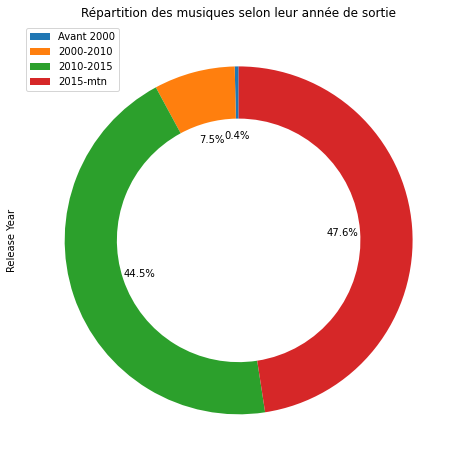

In [306]:
# Spécifier les intervalles et les étiquettes
bins = [0, 2000, 2010, 2015, 2023]
labels = ['Avant 2000', '2000-2010', '2010-2015', '2015-mtn']

# Créer le diagramme en camembert
plt.figure(figsize=(8, 8))
pd.cut(dataframe['Release Year'], bins=bins, labels=labels, include_lowest=True).value_counts().sort_index().plot.pie(autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), labels=None)

plt.title("Répartition des musiques selon leur année de sortie")
plt.legend(labels=labels, loc='upper left')
plt.show()

On remarque que nos données sont réparties uniformement entre 2010-2015 et 2015-présent. Avec le reste partagé entre 2000-2010 et avant 2000 qui n'occupe que 0.4%

Regardons maintenant comment sont réparties les musiques populaires au travers de nos artistes. Pour cela, nous définissons un seuil de 75, au delà duquel nous considérons que les musiques sont populaires. Nous regardons ensuite qui sont nos artistes les plus populaires.

In [307]:
popu_artists = dataframe[dataframe['Popularity'] > 75].groupby('Artist Name').count().sort_values('Track Name', ascending=False)
popu_artists = popu_artists.iloc[:,:1]
popu_artists.columns = ['total_pop_tracks']
popu_artists.head()

total_pop_tracks
Artist Name                     
Taylor Swift                  68
Drake                         28
Olivia Rodrigo                21
The Weeknd                    19
Bad Bunny                     13

### II. 3. Relation entre les variables 

#### II. 3.1. Choix de variables

Afin de choisir les variables à utiliser nous devons vérifier qu'ils n'existent pas de relation linéaire forte entre elles.

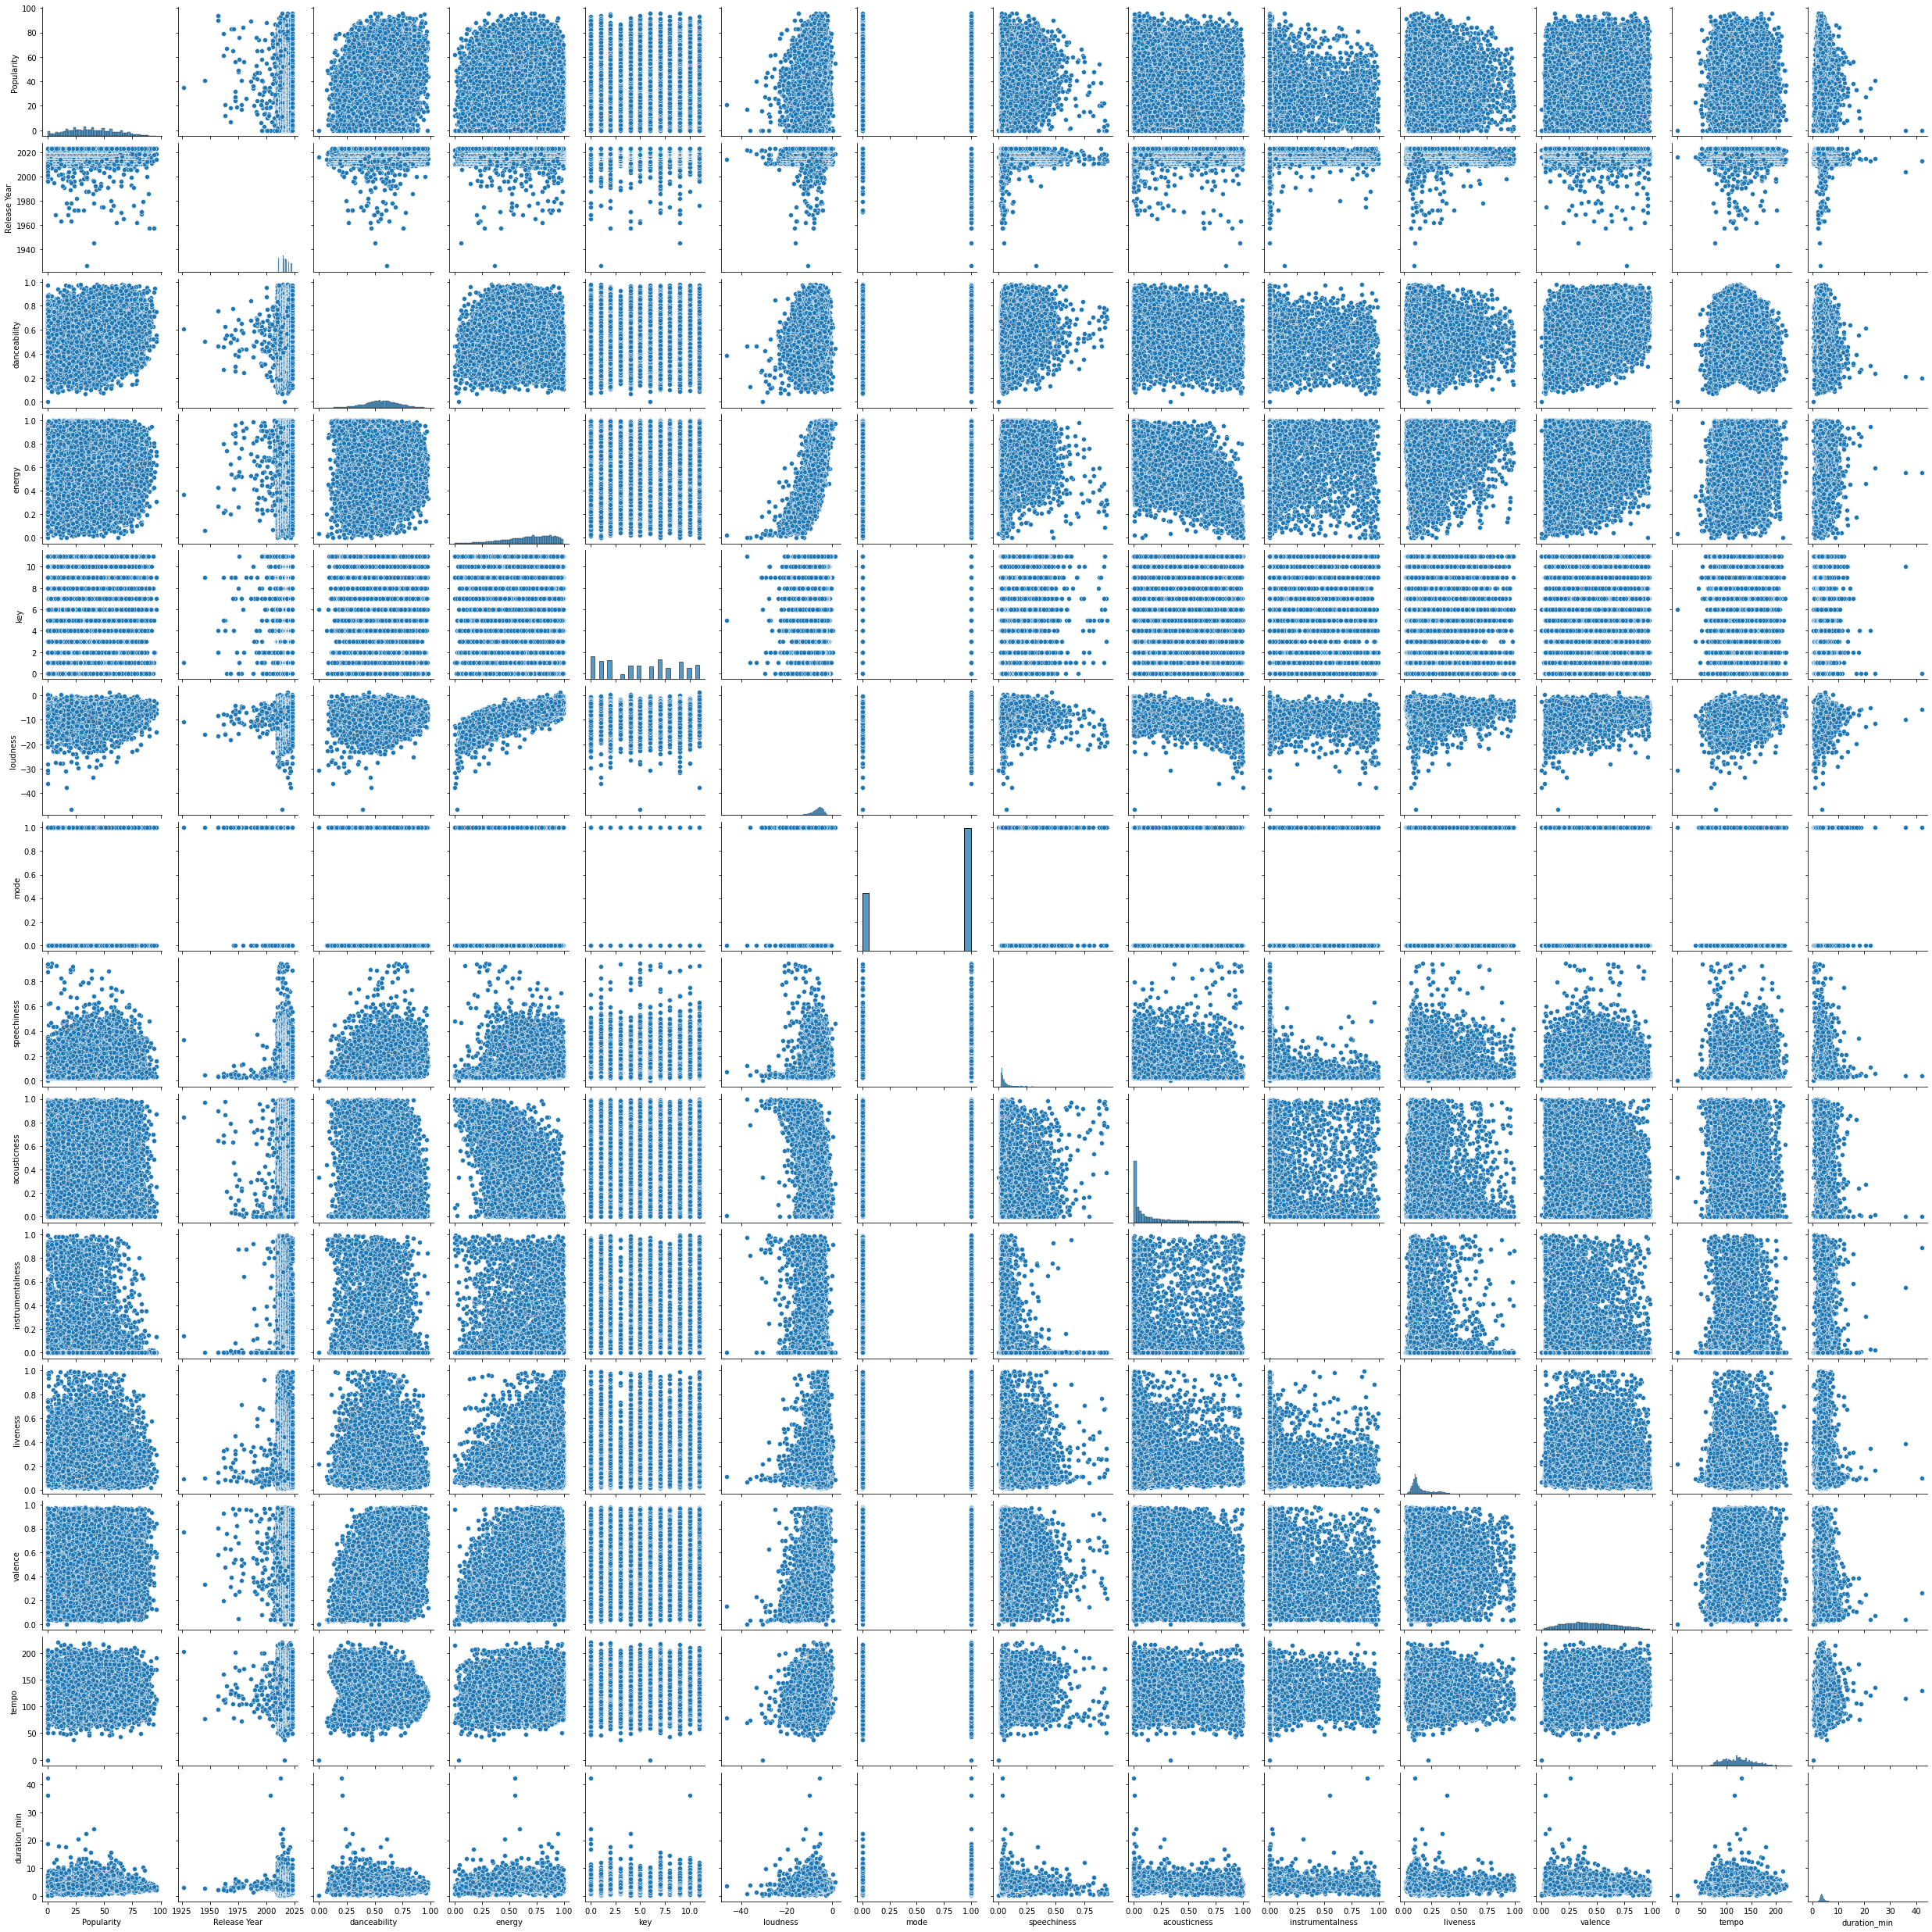

In [308]:
sns.pairplot(dataframe)

<AxesSubplot:xlabel='energy', ylabel='loudness'>

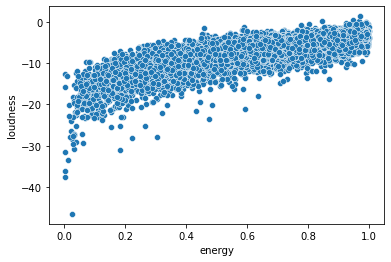

In [309]:
sns.scatterplot(x='energy', y='loudness', data=dataframe)

<AxesSubplot:xlabel='energy', ylabel='acousticness'>

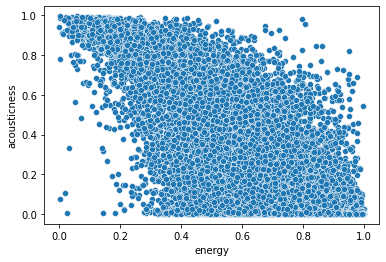

In [310]:
sns.scatterplot(x='energy', y='acousticness', data=dataframe)

Nous observons qu'il n'existe pas de relation linéaire évidente entre les paires de variables, à l'exception des 2 graphiques mettant en relation la variable `energy` avec `loudness` et `acousticness`, qui semblent indiquer une relation quasi-linéaire.

Vérifions cela à travers la matrice de corrélation.

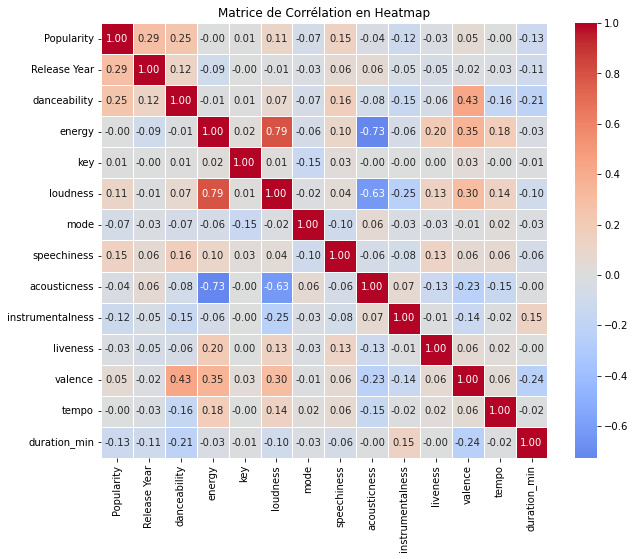

In [311]:
excluded_columns = ['Artist Name', 'Track Name']
selected_data = dataframe.drop(columns=excluded_columns)

correlation_matrix = selected_data.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, center=0, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Matrice de Corrélation en Heatmap')
plt.show()

Nous remarquons bien que la variable `energy` a une corrélation forte avec `loudness`, de plus elle a aussi une corrélation forte avec `accousticness`, supérieur à 0,70. D'autant plus que cette variable a une corrélation nulle avec `popularity`. Ce qui fait que nous décidons ainsi de l'enlever.

Nous remarquons aussi qu'aucune des variables n'a une corrélation forte ( proche de 1 ou -1) avec la popularité. Cela signifie qu'aucune variable individuelle ne peut prédire parfaitement la popularité. Cependant, cela ne signifie pas nécessairement qu'on ne peut pas prédire la popularité à partir de la combinaison de ces variables. 

In [312]:
dataframe.drop('energy', axis=1, inplace=True)

In [313]:
continuous_var.remove('energy')
print(continuous_var)

['Popularity', 'danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_min']


#### II. 3.2. Relation entre Popularity et les autres variables

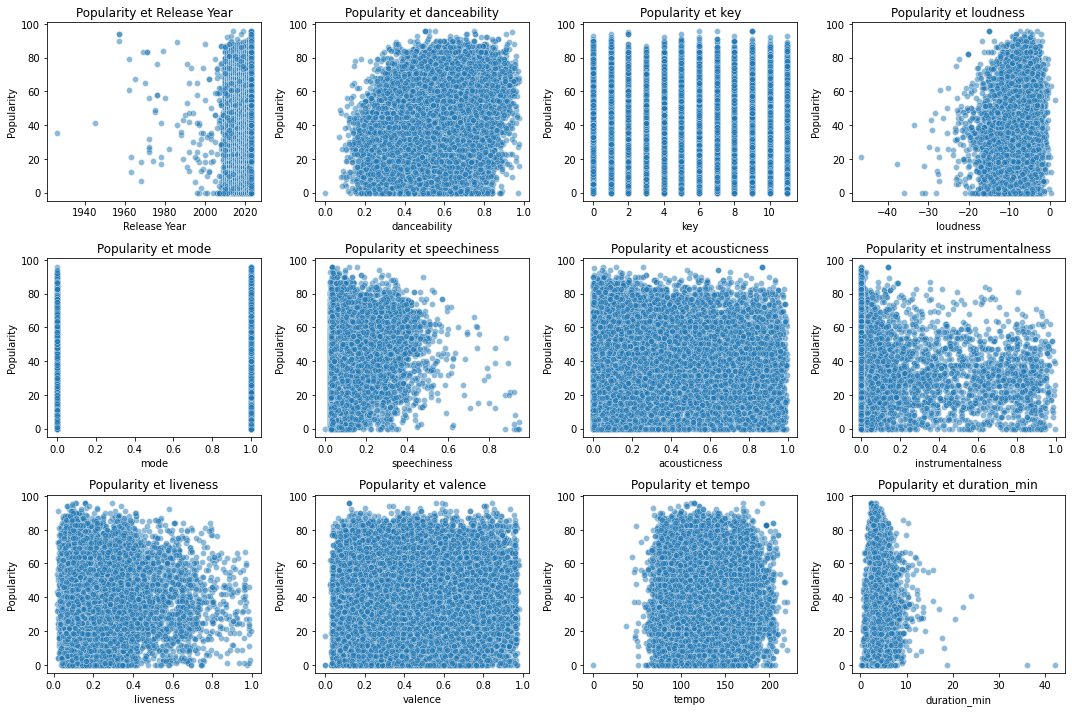

In [314]:
# Variables spécifiées
autres_variables = ['Release Year', 'danceability', 'key', 'loudness', 'mode',
                    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
                    'tempo', 'duration_min']

# Calculer le nombre de lignes et de colonnes nécessaires pour les graphiques
num_rows = 3
num_cols = (len(autres_variables) + num_rows - 1) // num_rows

# Créer une grille de sous-tracés avec 3 lignes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Aplatir la grille pour itérer facilement sur les sous-tracés
axes = axes.flatten()

# Itérer sur les variables et créer les graphiques
for i, variable in enumerate(autres_variables):
    sns.scatterplot(x=variable, y='Popularity', data=dataframe, ax=axes[i], alpha=0.5)
    axes[i].set_title(f"Popularity et {variable}")

# Supprimer les sous-tracés inutilisés (s'il y en a)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les sous-tracés pour une meilleure lisibilité
fig.tight_layout()

# Afficher les graphiques
plt.show()

Ces graphiques mettent bien en évidence la difficulté à percevoir une relation linéaire entre la popularité et le reste des variables. Cependant, comme nous l'avons expliqué cela n'exclut pas la possibilité d'une relation linéaire entre la popularité et l'ensemble des variables.

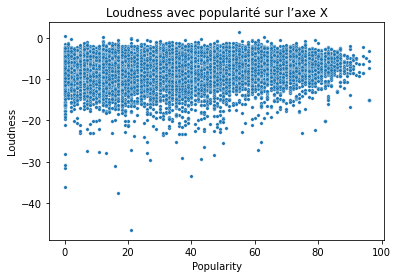

In [315]:
sns.scatterplot(x='Popularity', y='loudness',data=dataframe, s=12)

plt.xlabel('Popularity')
plt.ylabel('Loudness')
plt.title('Loudness avec popularité sur l’axe X')

plt.show()

Le graphique ci-dessus montre la distribution du Loudness avec popularité sur l’axe X. Cela montre que les valeurs de Loudness les plus élevées peuvent être trouvées dans tout le spectre de popularité, mais que à mesure que l'axe X augmente, les groupements deviennent de plus en plus concentrés vers le sommet. En d’autres termes, Loudness ne garantit pas la popularité, mais de faibles niveaux de Loudness semblent exclure la popularité.

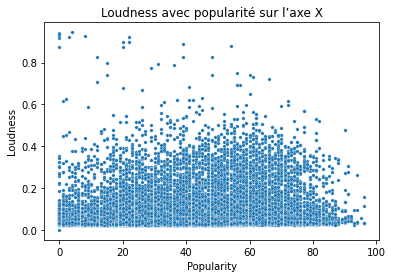

In [316]:
sns.scatterplot(x='Popularity', y='speechiness',data=dataframe, s=12)

plt.xlabel('Popularity')
plt.ylabel('Loudness')
plt.title('Loudness avec popularité sur l’axe X')

plt.show()

De même, nous remarquons que des niveaux élevés de `Loudness` semblent exclure la popularité.

### II. 4. Elimination des valeurs abérrantes 

Afin de visualiser les valeurs abérrantes, nous commençons par regarder le min et max des différentes variables continues

In [317]:
dataframe[continuous_var].describe().round(2)

Popularity  danceability  loudness  speechiness  acousticness  \
count    21030.00      21030.00  21030.00     21030.00      21030.00   
mean        39.00          0.56     -6.66         0.08          0.21   
std         20.81          0.15      3.07         0.09          0.28   
min          0.00          0.00    -46.51         0.00          0.00   
25%         23.00          0.46     -7.93         0.03          0.01   
50%         38.00          0.56     -6.00         0.05          0.08   
75%         55.00          0.66     -4.63         0.08          0.34   
max         96.00          0.98      1.35         0.94          1.00   

       instrumentalness  liveness   valence     tempo  duration_min  
count          21030.00  21030.00  21030.00  21030.00      21030.00  
mean               0.05      0.19      0.45    123.38          3.86  
std                0.16      0.14      0.22     29.50          1.15  
min                0.00      0.02      0.00      0.00          0.17  
25%                0.00      0.10      0.27    100.00          3.25  
50%                0.00      0.13      0.43    122.05          3.69  
75%                0.00      0.24      0.62    142.76          4.25  
max                1.00      1.00      0.98    220.22         42.18

Nous savons déjà d'après la documentation de l'API spotify que les variables :  Acousticness, Danceability, Instrumentalness, Liveness, Speechiness et Valence ont des valeurs entre 0 et 1.
Donc nous nous intéressons qu'aux variables : Popularity, Duration_s, Tempo et Loudness pour vérifier si on a des outliers dans notre dataset.

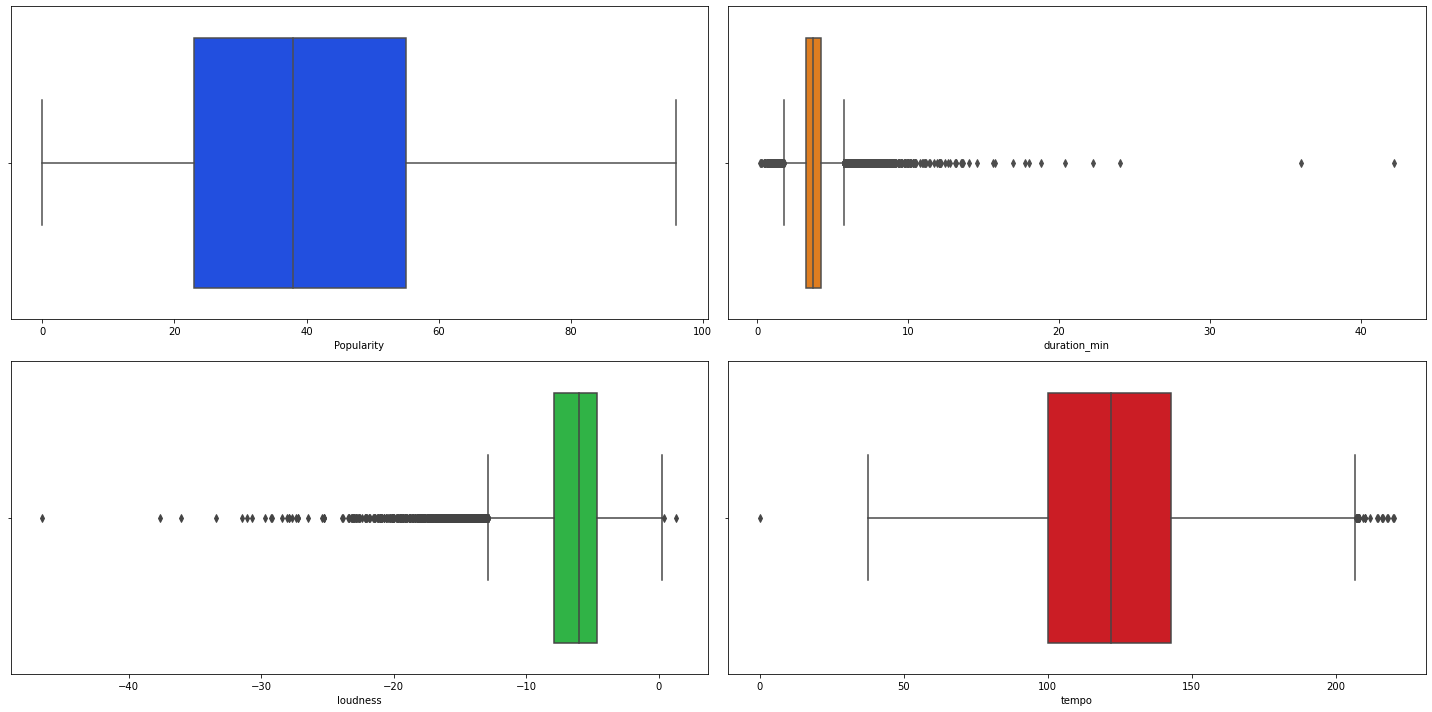

In [318]:
selected_vars = ['Popularity', 'duration_min', 'loudness', 'tempo']

clr = sns.color_palette('bright', len(selected_vars))

n = 2 

plt.figure(figsize=[20, 5 * math.ceil(len(selected_vars) / n)])
for i in range(len(selected_vars)):
    plt.subplot(math.ceil(len(selected_vars) / n), n, i + 1)
    sns.boxplot(x=dataframe[selected_vars[i]], color=clr[i])
plt.tight_layout()
plt.show()

En examinant notre ensemble de données, nous remarquons l'existence de valeurs aberrantes qui peuvent influencer négativement nos analyses. Pour avoir de meilleurs résultats, nous avons décidé d'éliminer ces valeurs extrêmes. En retirant ces observations, nous nous assurons d'obtenir des analyses plus fiables et représentatives de l'ensemble des données:

In [319]:
for var in selected_vars:
    Q1=dataframe[var].quantile(0.25)
    Q3=dataframe[var].quantile(0.75)
    IQR=Q3-Q1
    dataframe=dataframe[(dataframe[var]>=Q1-1.5*IQR)&(dataframe[var]<=Q3+1.5*IQR)]

#  III. Modélisation

## III. 1. Data Preprocessing

Etant donné que les 2 variables : `key` et `mode` sont des variables catégorielles.
Les 2 variables prennent des valeurs bien précises et ces valeurs ne sont pas ordinales. 

Nous utilisons ainsi le One-hot encoding afin que nos modèles spécialement linéaires ne les interprétent pas comme des données ordinales mais plutôt comme des catégories.

De plus, afin de ne pas tomber dans le "Dummy Variable Trap", on va drop la première variable (colonne) des dummies variables.  

Même si la variable mode a deux catégories: Minor et Major, on n'a pas besoin de l'encoder. Si on le fait, on aura deux colonnes : mode_0 et mode_1 qui sont parfaitement négativement corrélés ce qui fait qu'on aura de la redondance d'informations.

In [322]:
dataframe = pd.get_dummies(dataframe, columns=['key'], drop_first=True)

In [330]:
X = dataframe.drop(columns= ['Popularity', 'Track Name','Artist Name'])
y = dataframe['Popularity']

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [331]:
print(X_train.columns)

Index(['Release Year', 'danceability', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_min', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6',
       'key_7', 'key_8', 'key_9', 'key_10', 'key_11'],
      dtype='object')


Dans cette étape du prétraitement, nous utilisons la méthode de la mise à l'échelle standard pour normaliser les caractéristiques numériques de notre ensemble de données. Nos variables explicatives auront par la suite une moyenne de 0 et un écart type de 1, ce qui permet de traiter toutes les caractéristiques sur pied d'égalité indépendamment de leur échelle d'origine.

In [332]:
scaler = StandardScaler()

# List of columns to scale
columns_to_scale = ['Release Year', 'danceability', 'loudness', 'speechiness', 'acousticness',
                       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_min']


# Fit the scaler and transform the columns of X_train
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# Transform the columns of X_test using the same scaler
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

c:\Users\tahah\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
c:\Users\tahah\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


## III. 2. Les modèles

Cette section détaille les étapes entreprises pour identifier l'algorithme optimal dans la prédiction de la popularité.

### III. 2.1. Modèles linéaires basiques

 Nous avons commencé par appliquer un modèle de régression linéaire basique, puis nous avons utilisé Ridge. Même en utilisant une régularisation avec la régression ridge, les résultats demeuraient insatisfaisants, comme le suggèrent les nombreuses visualisations précédentes.Ensuite j'ai progressé vers des méthodes d'ensemble telles que le bagging, le Random Forest et le boosting, ce qui a amélioré la précision.

Pour surmonter les difficultés rencontrées, j'ai décidé d'augmenter la taille de ma base de données. Cette décision a été motivée par le constat de problèmes liés à l'utilisation de ma base de données initiale réduite, notamment des résultats de modélisation insatisfaisants et une performance médiocre des algorithmes. L'expansion de la base de données visait à atténuer ces problèmes, fournissant ainsi un ensemble de données plus robuste et informatif pour l'entraînement des modèles.

#### III. 2.1.1. Régression linéaire

In [333]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [334]:
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 361.05778654591904


Nous trouvons une valeurs trop elevé pour l'erreur quadratique moyenne. Visualisons de plus près la prédiction.

In [335]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(9,6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

In [336]:
def plot_coefficients(model, X_train):
    # Récupérer les coefficients
    coefficients = model.coef_

    # Créer une série pour faciliter le tracé
    coef_series = pd.Series(coefficients, index=X_train.columns)

    # Tracer les coefficients
    plt.figure(figsize=(10, 5))
    coef_series.plot(kind='bar')
    plt.title('Coefficients des Variables')
    plt.show()

C:\Users\tahah\AppData\Local\Temp/ipykernel_10824/2765966909.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='r')


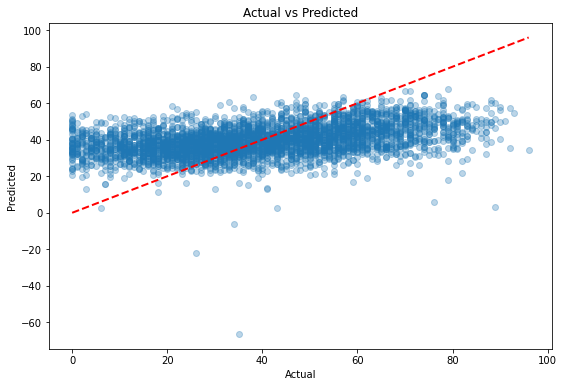

In [337]:
plot_actual_vs_predicted(y_test, y_pred)

Nous remarquons que la plupart des valeurs prédites sont autour de 39, ce qui n'est autre que la moyenne de notre popularité de la base de données. Avant de trancher que les variables explicatives ou les données ne sont pas adéquates nous allons tester plus de modèles.

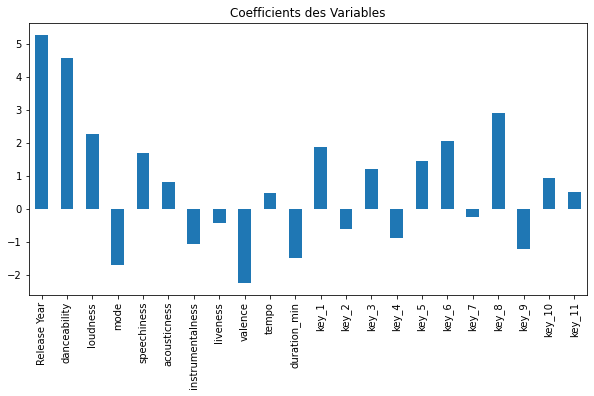

In [338]:
plot_coefficients(model, X_train)

Nous remarquons que notre prédiction linéaire n'est pas efficace. 

### III. 2.1.2. Régression de Ridge

In [339]:
# Les valeurs d'alpha à tester
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Créer un objet RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Adapter le modèle aux données d'entraînement
ridge_cv.fit(X_train, y_train)

# Obtenir le alpha optimal
optimal_alpha = ridge_cv.alpha_
print(f"Alpha optimal : {optimal_alpha}")

# Prédire sur l'ensemble de test
y_pred = ridge_cv.predict(X_test)

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error pour alpha optimal : {mse}")

Alpha optimal : 100.0
Mean Squared Error pour alpha optimal : 361.03955705976983


Même MSE à peu près, donc l'ajout de la régularisation dans la regression de Ridge n'a pas conduit à une amélioration de la performance.

C:\Users\tahah\AppData\Local\Temp/ipykernel_10824/2765966909.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='r')


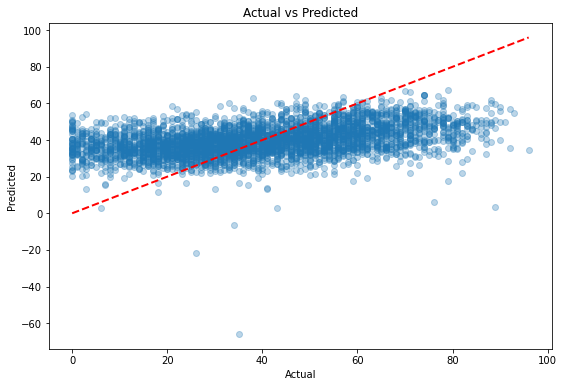

In [340]:
plot_actual_vs_predicted(y_test, y_pred)

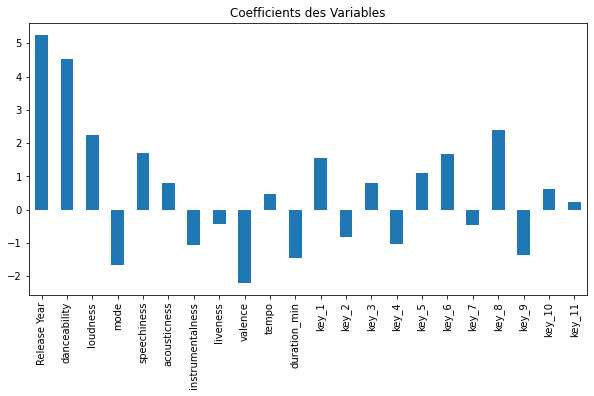

In [341]:
plot_coefficients(ridge_cv, X_train)

Nous retrouvons un peu les mêmes résultats, la plupart des valeurs prédites sont autour de 39, et les coefficients sont les mêmes. On conclut que les 2 modèles ne font qu'une moyenne sur les données et n'essaient pas d'apprendre 
Cela suggère que nos modèles ont tendance à prédire des valeurs proches de la moyenne, ce qui pourrait indiquer qu'ils ne sont pas suffisamment sensibles aux variations dans les caractéristiques des données. Il serait donc bénéfique d'explorer d'autres modèles ou techniques pour améliorer la performance de nos modèles.

### III. 2.2. Modèles de regréssions plus complexes

### III. 2.2.1. Random Forest Regressor 

In [342]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 334.8486932427108


C:\Users\tahah\AppData\Local\Temp/ipykernel_10824/2765966909.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='r')


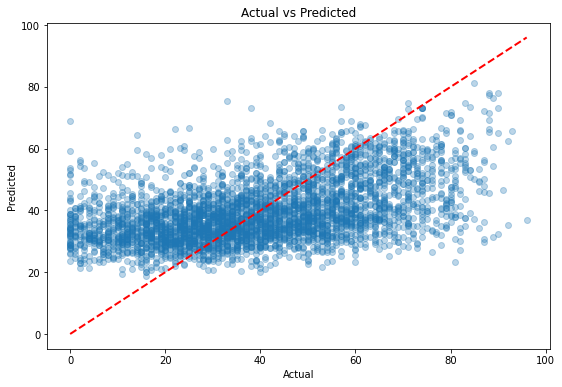

In [343]:
plot_actual_vs_predicted(y_test, y_pred)

Nous remarquons qu'on a une petite amélioration pour les popularité les plus élevés, cependant notre modèle n'arrive toujours pas à trouver une relation entre les données.

### III. 2.2.2. Gradient Boosting Regressor

In [344]:
# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model on the training data
gbr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gbr.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 332.3586148126414


C:\Users\tahah\AppData\Local\Temp/ipykernel_10824/2765966909.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='r')


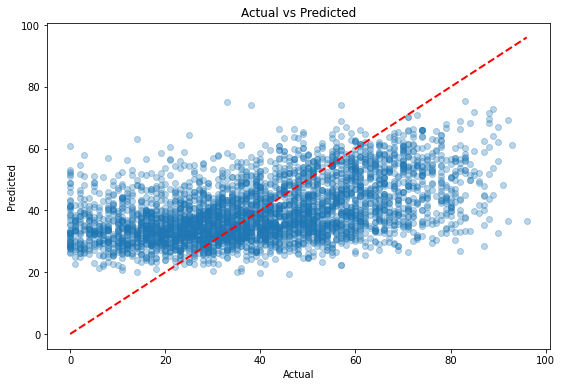

In [345]:
plot_actual_vs_predicted(y_test, y_pred)

Même si on a une petite amélioration encore avec ce modèle de Gradient Boosting Regressor, ce n'est pas suffisant, vu qu'une MSE de `332` signifie que nos prédictions sont en moyenne à une distance de la racine carrée de `332` (soit environ `18.2`) des valeurs réelles. C'est une erreur qui reste assez importante si nous considérons l'échelle de notre variable cible.

#  IV. Solutions

Afin d'améliorer les résultats, nous commencerons d'abord par transformer le problème en un problème de classification. De plus, nous essayerons dans un second temps d'augmenter la base de données pour obtenir une base plus homogène.

## IV.1. Classification

le code qui suit crée un modèle de classification pour prédire la popularité des chansons. Pour cela, nous divisons d'abord la base de données à l'aide d'un seuil que nous fixons à 75%, et qu'au delà de ce seuil, nous considérons les musiques comme populaires.

In [369]:
# Définir le seuil de popularité (les 25% les plus populaires comme "populaires")
seuil_de_popularite = dataframe['Popularity'].quantile(0.75)
dataframe['is_popular'] = (dataframe['Popularity'] >= seuil_de_popularite).astype(int)

# Caractéristiques et variable cible
caracteristiques = dataframe.drop(['Popularity', 'is_popular','Artist Name', 'Track Name'], axis=1) 
cible = dataframe['is_popular']

In [370]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(caracteristiques, cible, test_size=0.2, random_state=42)

In [371]:
# Créer et entraîner le modèle (Random Forest Classifier comme exemple)
modele = RandomForestClassifier(random_state=42)
modele.fit(X_train, y_train)

# Faire des prédictions
predictions = modele.predict(X_test)

# Évaluer le modèle
exactitude = accuracy_score(y_test, predictions)
rapport = classification_report(y_test, predictions)

print(f"Exactitude du modèle : {exactitude}")
print("Rapport de classification :\n", rapport)

Exactitude du modèle : 0.7851326503808773
Rapport de classification :
               precision    recall  f1-score   support

           0       0.80      0.94      0.87      2800
           1       0.69      0.34      0.46      1007

    accuracy                           0.79      3807
   macro avg       0.74      0.64      0.66      3807
weighted avg       0.77      0.79      0.76      3807



Nous remarquons que notre modèle a une précision de 78,5 % ce qui signifie qu'il a correctement prédit 78.5% des cas de test. 
Cependant, la précision pour la classe 1 est de 0.69, ce qui signifie que lorsque le modèle prédit qu'une chanson est populaire il a raison 69% du temps. 
Ces résultats montrent qu'il y a un déséquilibre dans nos données. On a beaucoup de chansons non populaires que des chansons populaires.

## IV.2. Augmentation de la base de données

### IV.2.1. Concaténation des deux bases de données

Afin d'avoir de meilleurs résultats, nous allons combiner notre base de données `data1` à une deuxième base de données de données de 169k musiques `data2`. 

In [408]:
data1 = pd.read_csv('dataframe.csv')

In [409]:
data2 = pd.read_csv('data.csv')


In [410]:
data1.columns

Index(['Track Name', 'Artist Name', 'Popularity', 'Release Year',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_min'],
      dtype='object')

In [411]:
data2.columns


Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

In [412]:
data2.head()


acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       104300  0.2200         0  6L63VW0PibdM1HDSBoqnoM             0.000   
3       180760  0.1300         0  6M94FkXd15sOAOQYRnWPN8             0.887   
4       687733  0.2040         0  6N6tiFZ9vLTSOIxkj8qKrd             0.908   

   key  liveness  loudness  mode  \
0   10    0.1510   -12.428     1   
1    8    0.0763   -28.454     1   
2    5    0.1190   -19.924     0   
3    1    0.1110   -14.734     0   
4   11    0.0980   -16.829     1   

                                            name  popularity release_date  \
0                    Singende Bataillone 1. Teil           0         1928   
1       Fantasiestücke, Op. 111: Più tosto lento           0         1928   
2                 Chapter 1.18 - Zamek kaniowski           0         1928   
3  Bebamos Juntos - Instrumental (Remasterizado)           0   1928-09-25   
4    Polonaise-Fantaisie in A-Flat Major, Op. 61           1         1928   

   speechiness    tempo  valence  year  
0       0.0506  118.469   0.7790  1928  
1       0.0462   83.972   0.0767  1928  
2       0.9290  107.177   0.8800  1928  
3       0.0926  108.003   0.7200  1928  
4       0.0424   62.149   0.0693  1928

Nous remarquons que les noms des colonnes ne sont pas les mêmes, en plus de quelques colonnes qu'on n'a pas dans notre base de données. D'autant plus les noms d'artiste sont stockés sous forme de liste.

Corrigeons tout cela ! 

In [413]:
data2.drop(columns=['explicit', 'id', 'release_date'], inplace=True)
data2['duration_ms'] = data2['duration_ms'] /60000  
data2 = data2.rename(columns={
    'artists': 'Artist Name',
    'name': 'Track Name',
    'year': 'Release Year',
    'popularity': 'Popularity',
    'duration_ms': 'duration_min', 
})


print(data2.columns)

Index(['acousticness', 'Artist Name', 'danceability', 'duration_min', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'Track Name',
       'Popularity', 'speechiness', 'tempo', 'valence', 'Release Year'],
      dtype='object')


In [415]:
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   Artist Name       169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_min      169909 non-null  float64
 4   energy            169909 non-null  float64
 5   instrumentalness  169909 non-null  float64
 6   key               169909 non-null  int64  
 7   liveness          169909 non-null  float64
 8   loudness          169909 non-null  float64
 9   mode              169909 non-null  int64  
 10  Track Name        169909 non-null  object 
 11  Popularity        169909 non-null  int64  
 12  speechiness       169909 non-null  float64
 13  tempo             169909 non-null  float64
 14  valence           169909 non-null  float64
 15  Release Year      169909 non-null  int64  
dtypes: float64(10), int6

In [416]:
print(data1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21030 entries, 0 to 21029
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track Name        21030 non-null  object 
 1   Artist Name       21030 non-null  object 
 2   Popularity        21030 non-null  float64
 3   Release Year      21030 non-null  int64  
 4   danceability      21030 non-null  float64
 5   energy            21030 non-null  float64
 6   key               21030 non-null  int64  
 7   loudness          21030 non-null  float64
 8   mode              21030 non-null  int64  
 9   speechiness       21030 non-null  float64
 10  acousticness      21030 non-null  float64
 11  instrumentalness  21030 non-null  float64
 12  liveness          21030 non-null  float64
 13  valence           21030 non-null  float64
 14  tempo             21030 non-null  float64
 15  duration_min      21030 non-null  float64
dtypes: float64(11), int64(3), object(2)
memo

In [ ]:
# Convertir les éléments de la colonne "Artist Name" en listes
data2['Artist Name'] = data2['Artist Name'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Utiliser la fonction lambda pour convertir la liste en une chaîne de caractères
data2['Artist Name'] = data2['Artist Name'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

data2.head()

acousticness                         Artist Name  danceability  \
0         0.995                     Carl Woitschach         0.708   
1         0.994  Robert Schumann, Vladimir Horowitz         0.379   
2         0.604                 Seweryn Goszczyński         0.749   
3         0.995                    Francisco Canaro         0.781   
4         0.990  Frédéric Chopin, Vladimir Horowitz         0.210   

   duration_min  energy  instrumentalness  key  liveness  loudness  mode  \
0      2.644133  0.1950             0.563   10    0.1510   -12.428     1   
1      4.702217  0.0135             0.901    8    0.0763   -28.454     1   
2      1.738333  0.2200             0.000    5    0.1190   -19.924     0   
3      3.012667  0.1300             0.887    1    0.1110   -14.734     0   
4     11.462217  0.2040             0.908   11    0.0980   -16.829     1   

                                      Track Name  Popularity  speechiness  \
0                    Singende Bataillone 1. Teil           0       0.0506   
1       Fantasiestücke, Op. 111: Più tosto lento           0       0.0462   
2                 Chapter 1.18 - Zamek kaniowski           0       0.9290   
3  Bebamos Juntos - Instrumental (Remasterizado)           0       0.0926   
4    Polonaise-Fantaisie in A-Flat Major, Op. 61           1       0.0424   

     tempo  valence  Release Year  
0  118.469   0.7790          1928  
1   83.972   0.0767          1928  
2  107.177   0.8800          1928  
3  108.003   0.7200          1928  
4   62.149   0.0693          1928

Maintenant que les deux datasets ont les mêmes colonnes et le même type d'éléments, concaténons les 2

In [ ]:
# Concaténer les deux DataFrames verticalement
merged_data = pd.concat([data2, data1], ignore_index=True, sort=False)

# Supprimer les lignes en double basées sur les colonnes "Track Name" et "Artist Name"
merged_data = merged_data.drop_duplicates(subset=['Track Name', 'Artist Name'])

# Réinitialiser l'index après la suppression des doublons
merged_data.reset_index(drop=True, inplace=True)


Vérifions qu'on n'a pas de valeurs Nan

In [ ]:
# Compter le nombre de valeurs NaN dans chaque colonne avant la suppression
nan_count_before = merged_data.isnull().sum()

# Afficher le nombre de valeurs NaN par colonne
print(nan_count_before)

acousticness        0
Artist Name         0
danceability        0
duration_min        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
Track Name          0
Popularity          0
speechiness         0
tempo               0
valence             0
Release Year        0
dtype: int64


### IV.1.2. Visualisation de la nouvelle base de données

In [ ]:
merged_data.head()

acousticness                         Artist Name  danceability  \
0         0.995                     Carl Woitschach         0.708   
1         0.994  Robert Schumann, Vladimir Horowitz         0.379   
2         0.604                 Seweryn Goszczyński         0.749   
3         0.995                    Francisco Canaro         0.781   
4         0.990  Frédéric Chopin, Vladimir Horowitz         0.210   

   duration_min  energy  instrumentalness   key  liveness  loudness  mode  \
0      2.644133  0.1950             0.563  10.0    0.1510   -12.428   1.0   
1      4.702217  0.0135             0.901   8.0    0.0763   -28.454   1.0   
2      1.738333  0.2200             0.000   5.0    0.1190   -19.924   0.0   
3      3.012667  0.1300             0.887   1.0    0.1110   -14.734   0.0   
4     11.462217  0.2040             0.908  11.0    0.0980   -16.829   1.0   

                                      Track Name  Popularity  speechiness  \
0                    Singende Bataillone 1. Teil           0       0.0506   
1       Fantasiestücke, Op. 111: Più tosto lento           0       0.0462   
2                 Chapter 1.18 - Zamek kaniowski           0       0.9290   
3  Bebamos Juntos - Instrumental (Remasterizado)           0       0.0926   
4    Polonaise-Fantaisie in A-Flat Major, Op. 61           1       0.0424   

     tempo  valence  Release Year  
0  118.469   0.7790        1928.0  
1   83.972   0.0767        1928.0  
2  107.177   0.8800        1928.0  
3  108.003   0.7200        1928.0  
4   62.149   0.0693        1928.0

Visualisons la distribution de 'Popularity' dans notre nouvelle base de données

Moyenne de la Popularité : 31.36
Écart type de la Popularité : 21.28


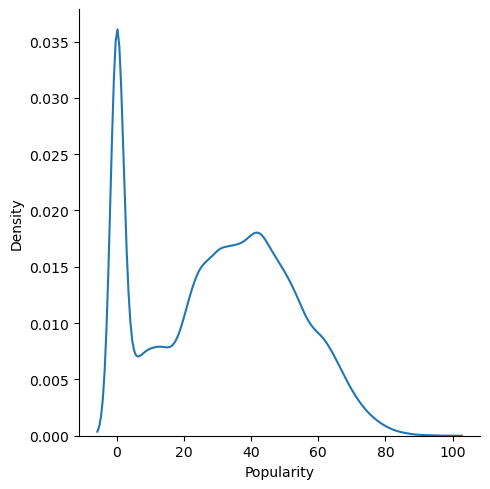

In [ ]:
# Générer un graphique KDE
sns.displot(merged_data['Popularity'], kind='kde')

# Extraire les valeurs numériques associées au graphique
kde = gaussian_kde(merged_data['Popularity'])
x_values = np.linspace(min(merged_data['Popularity']), max(merged_data['Popularity']), 1000)
y_values = kde(x_values)

# Calculer la moyenne et l'écart type
moyenne = np.mean(merged_data['Popularity'])
ecart_type = np.std(merged_data['Popularity'])

# Afficher les statistiques numériques
print(f"Moyenne de la Popularité : {moyenne:.2f}")
print(f"Écart type de la Popularité : {ecart_type:.2f}")

nous remarquons qu'il n'existe pas un nombre important des musiques populaires (plus que 80)

cherchons des Relations entre Popularity et les autres variables dans la nouvelle base 

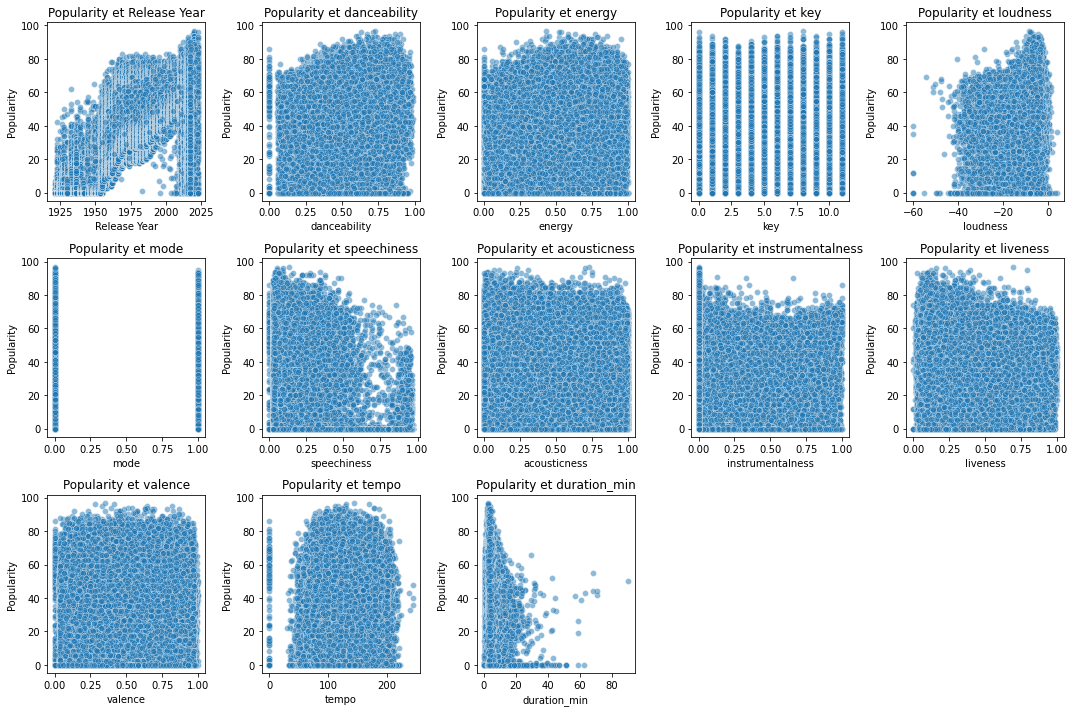

In [ ]:
# Variables spécifiées
autres_variables = ['Release Year', 'danceability', 'energy', 'key', 'loudness', 'mode',
                    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
                    'tempo', 'duration_min']

# Calculer le nombre de lignes et de colonnes nécessaires pour les graphiques
num_rows = 3
num_cols = (len(autres_variables) + num_rows - 1) // num_rows

# Créer une grille de sous-tracés avec 3 lignes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Aplatir la grille pour itérer facilement sur les sous-tracés
axes = axes.flatten()

# Itérer sur les variables et créer les graphiques
for i, variable in enumerate(autres_variables):
    sns.scatterplot(x=variable, y='Popularity', data=merged_data, ax=axes[i], alpha=0.5)
    axes[i].set_title(f"Popularity et {variable}")

# Supprimer les sous-tracés inutilisés (s'il y en a)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les sous-tracés pour une meilleure lisibilité
fig.tight_layout()

# Afficher les graphiques
plt.show()

Nous remarquons que dans le cas général, la popularité est une fonction croissante de l'année de sortie. Cependant, pour le reste des variables il n'y a pas de relation linéaire avec `Popularity`

Regardons de plus près ces relations à travers la matrice de corrélation

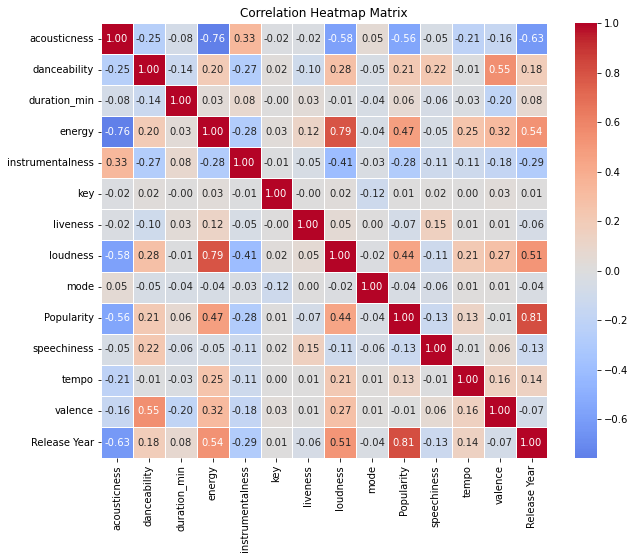

In [ ]:
excluded_columns = ['Artist Name', 'Track Name']

selected_data_2 = merged_data.drop(columns=excluded_columns)

correlation_matrix_2 = selected_data_2.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix_2, annot=True, center=0, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Heatmap Matrix')
plt.show()

Nous remarquons que contrairement à la première base de données, nous avons des coefficients plus élevés dans la ligne de `Popularity`. Nous remarquons qu'encore `energy` est fortement corrélé avec `loudness` et `acousticness`. 
Même si la corrélation entre `Popularity` et `energy` est importante nous décidons de l'enlever. En effet, les variables avec lesquelles elle est corrélée ont une corrélation plus forte avec `popularity`.

In [ ]:
merged_data.drop('energy', axis=1, inplace=True)

### IV.1.3. Modélisation


### IV.1.3.1.Data Preprocessing

In [ ]:
X2 = merged_data.drop(columns= ['Popularity', 'Track Name', 'Artist Name'])

y2 = merged_data['Popularity']
print(merged_data.shape)
print(X2.shape)
print(y2.shape)


X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)





(169872, 15)
(169872, 12)
(169872,)


Nous utilisons une autre fois la méthode de la mise à l'échelle standard pour normaliser les caractéristiques numériques de notre nouveau ensemble de données.

In [ ]:
# Initialisation du scaler StandardScaler
scaler = StandardScaler()

# Liste des colonnes à normaliser
columns_to_scale = ['Release Year', 'danceability', 'loudness', 'speechiness', 'acousticness',
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_min']

# Adapter le scaler et transformer les colonnes de X_train
X2_train[columns_to_scale] = scaler.fit_transform(X2_train[columns_to_scale])

# Transformer les colonnes de X_test en utilisant le même scaler
X2_test[columns_to_scale] = scaler.transform(X2_test[columns_to_scale])



 ### IV.1.3.2.Les modèles

### IV.1.3.2.1.Regression linéaire

In [ ]:
model = LinearRegression()
model.fit(X2_train, y2_train)

LinearRegression()

In [ ]:
# Training accuracy
train_accuracy = model.score(X2_train, y2_train)
print(f"Training accuracy: {train_accuracy}")

# Test accuracy
R2_test = model.score(X2_test, y2_test)
print(f"R2: {test_accuracy}")

Training accuracy: 0.6728346927018435
Test accuracy: 0.6716161639162159


In [ ]:
y2_pred = model.predict(X2_test)

# Evaluate the model
mse = mean_squared_error(y2_test, y2_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 147.50894216716236


On remarque que la racine carré du MSE est d'environ 12 ce qui signifie que les prédictions de notre modèle sont en moyenne à 12 points de l'écart par rapport au score de popularité réelle.

## RESIDUAL PLOT

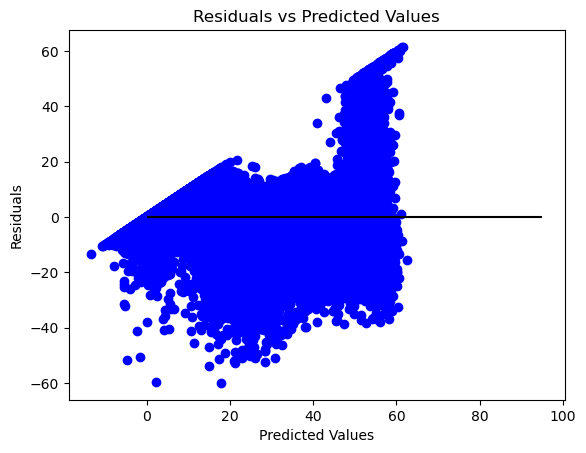

In [ ]:
plt.scatter(model.predict(X2_test), model.predict(X2_test) - y2_test, color='blue')
plt.hlines(y=0, xmin=y2_test.min(), xmax=y2_test.max(), colors='black')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

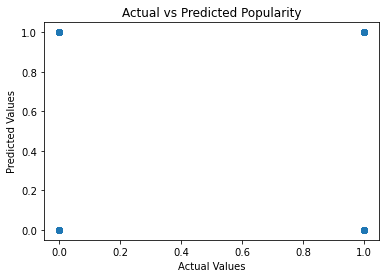

In [ ]:
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Popularity')
plt.show()

/tmp/ipykernel_6796/2765966909.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='r')


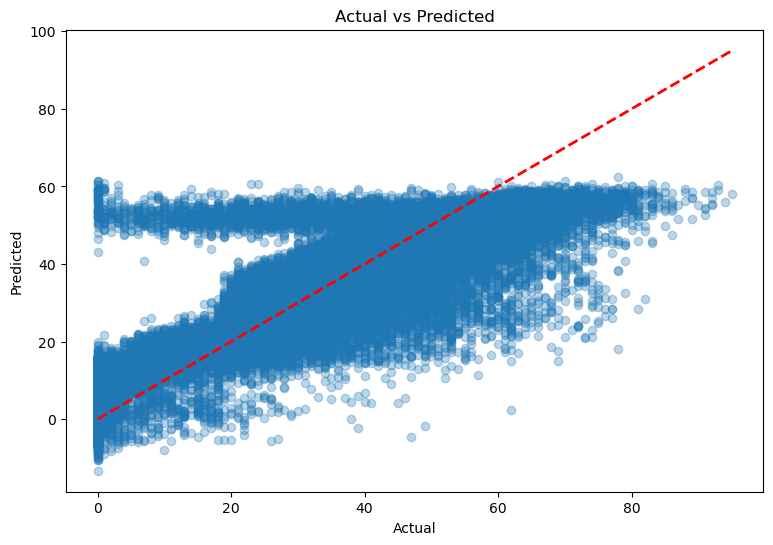

In [ ]:

plot_actual_vs_predicted(y2_test, y2_pred)

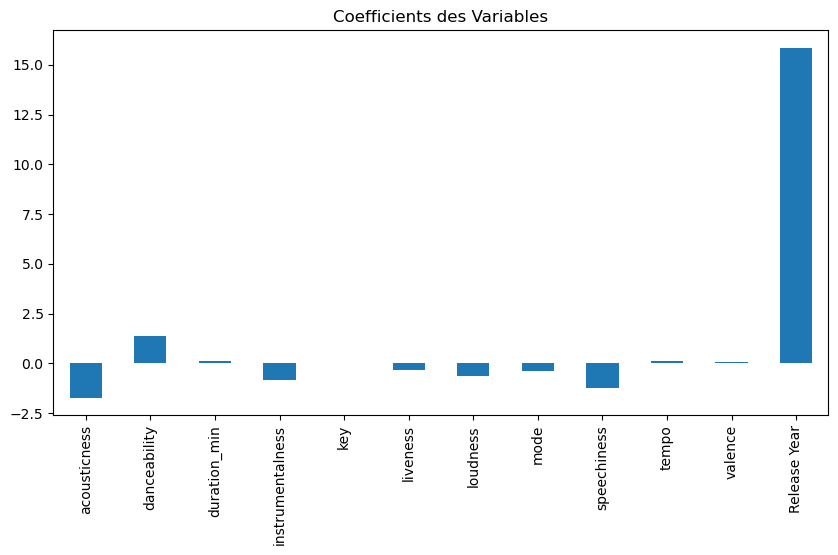

In [ ]:
plot_coefficients(model, X2_train)

Nous remarquons que le coefficient de Release_Year est le plus elevé, ce qui est logique d'après la documentation de l'API spotify. On a une pénalisation en popularité des musiques plus anciennes.

### IV.1.3.2.2.Random Forest Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à optimiser
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    # Ajouter d'autres hyperparamètres pertinents à optimiser
}

# Initialiser le Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialiser GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2')

# Ajuster le modèle aux données d'entraînement
grid_search.fit(X2_train, y2_train)

# Obtenir les meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres:", best_params)

# Utiliser le modèle avec les meilleurs hyperparamètres
best_rf = grid_search.best_estimator_

# Calculer et imprimer le R2 sur les ensembles d'entraînement et de test
R2_train = best_rf.score(X2_train, y2_train)
R2_test = best_rf.score(X2_test, y2_test)

print(f"Le R2 du train: {R2_train}")
print(f"Le R2 du test: {R2_test}")


KeyboardInterrupt: 

### IV.1.3.2.3.Gradient Boosting Regressor

In [ ]:
# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model on the training data
gbr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gbr.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

### IV.1.3.2.4.regression Lasso

Mean Squared Error: 148.5616552045241
R-squared: 0.6692726182272195


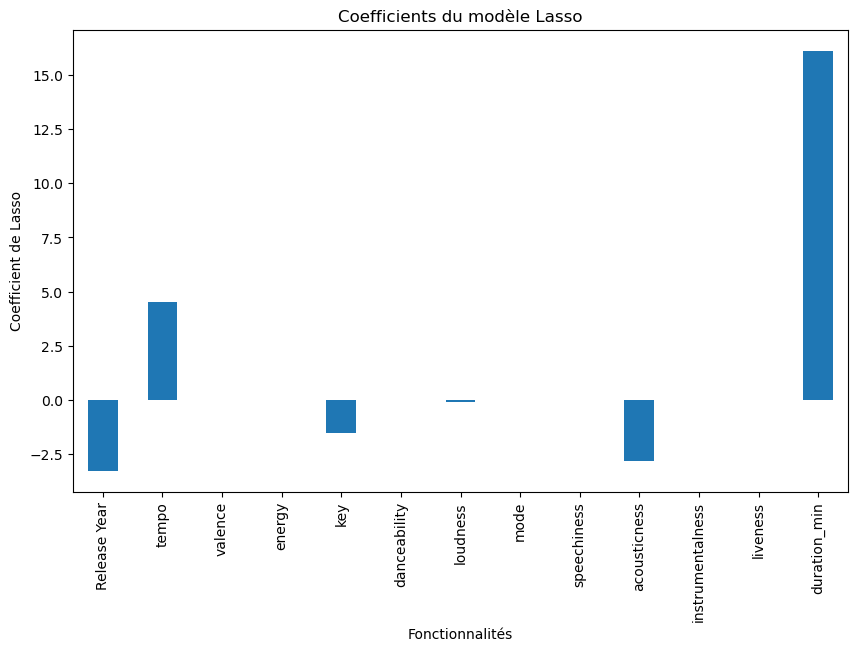

Release Year        -3.270528
tempo                4.528940
valence              0.000000
energy              -0.000000
key                 -1.506030
danceability         0.002811
loudness            -0.083183
mode                -0.000000
speechiness         -0.000000
acousticness        -2.802103
instrumentalness     0.002460
liveness             0.000000
duration_min        16.121443
dtype: float64


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV

features = ['Release Year','tempo','valence','energy','key','danceability', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'duration_min']

lasso_cv = LassoCV(cv=10)  
lasso_cv.fit(X2_train, y2_train)
best_alpha = lasso_cv.alpha_
alpha = best_alpha   
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X2_train, y2_train)
y2_pred = lasso_model.predict(X2_test)
mse = mean_squared_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Afficher les coefficients du modèle
coefficients = pd.Series(lasso_model.coef_,index=features)
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title("Coefficients du modèle Lasso")
plt.xlabel("Fonctionnalités")
plt.ylabel("Coefficient de Lasso")
plt.show()
coefficients = pd.Series(lasso_model.coef_, index=features)
print(coefficients)